## The advent of Big Data

**90%** of the data in the world today has been created in the last two years alone. Our current output of data is roughly 2.5 quintillion bytes a day. As the world steadily becomes more connected with an ever-increasing number of electronic devices, that’s only set to grow over the coming years. Now our local computers are not capable of loading and processing such huge chunks of data. I remember loading a 1GB file once into my local machine for analysis, and my machine was very slow in processing it(poor i3).The problem is that **Pandas** loads the entire dataset into the RAM. Thus processing large datasets takes time. Also we cannot load complete databases into Pandas.

The solution to this problem is **SQL**. We can use SQL to transform the data into something manageable by pandas before loading it in memory. SQL is very efficient slicing and dicing the data, but lacks the power of analytics as that in Pandas. To overcome this analytics incapability, Google has come up with its great product **BIGQUERY**.

**Google BigQuery** is a cloud-based big data analytics web service for processing very large read-only data sets.
BigQuery was designed for analyzing data on the order of billions of rows, using a SQL-like syntax. It runs on the Google Cloud Storage infrastructure and can be accessed with a REST-oriented application program interface (API). Now we cannot directly query BigTable using Pandas. So we need to first extract the desired data from the pool of data available, convert it into Pandas Dataframe and then explore and analyse it. BigQuery has support for SQL syntax, thus we will directly query and extract data from the BigTable using SQL and carry forward analysis using Pandas. 

This transition of BigTable data into Pandas Dataframe is very easy and is just 2-3 steps procedure. I would highly encourage you to please this **[BigQuery Starter Notebook by Megan Risdal](https://www.kaggle.com/mrisdal/safely-analyzing-github-projects-popular-licenses)**. Thanks a lot Megan for the notebook:)

Now coming to the Notebook, I will try to explore the Eclipse MegaMovie Dataset, which is a collection of photos submitted by a group of volunteers from locations across the United States during the August 21, 2017 total solar eclipse. I will also try to explain the SQL queries wherever needed.

##### If you like this notebook, Do upvote it. Thanks..!!

In [2]:
# Loading packages for analytics work
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')
import folium
import folium.plugins
from folium import IFrame
from matplotlib import animation,rc
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
import io
from scipy.misc import imread
import codecs
import base64
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Loading packages for BigQuery work
from bq_helper import BigQueryHelper
bq_assistant = BigQueryHelper("bigquery-public-data", "eclipse_megamovie")

Using Kaggle's public dataset BigQuery integration.


#### Lets first check what the columns of the dataset contain: 

**id:** Unique identifier for each photo.

**upload_session_id:** Identifier that joins all photos uploaded in a single session by a single user

**user:** A numeric ID which is unique for each user

**image_bucket:** The bucket the image was assigned to- 'megamovie' if the uploader was a member of the Megamovie Photo Team.

**storage_uri:** The URI at which the photo can be downloaded from Google Cloud Storage

**model:** The model of the camera

**make:** Company of the camera

**uploaded_date:** The date and time at which the photo was uploaded to the Megamovie website

**camera_datetime:** The time at which the photo was taken, according to the Camera clock

**image_datetime:** The date and time at which the photo was taken, as provided by GPS data or imputed from the camera_datetime

**datetime_repaired:** True if the image_datetime field was imputed from the camera_datetime and the timezone adjusted by the lat/lon

**lat:** Latitude at which photo was taken

**equatorial_mount:** Whether the camera was mounted equatorially (true) or not (false)

**lon:** Longitude at which the photo was taken

**State:** the US state that the photo was taken in

**image_type:** The file format of the image

**width:** Width of photo, in pixels

**height:** Height of the photo, in pixels

**detected_circle:**.radius - the radius of the detected circle (in pixels), .cx - the x coordinate center of the detected circle (in pixels), .cy - the y coordinate center of the detected circle (in pixels)
exposure time: The exposure time of the photograph, represented as a ratio

**vision_labels:** list of labels predicted for the image by Google Cloud Vision

**is_mobile:** whether the photo was taken on a mobile phone

**totality:** whether the photo is predicted to be in totality by its GPS lat/lon/image_datetime

### Firing the Simplest Query (checking total rows in the file)

In [4]:
Query="""
Select count(*) as count
From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`"""

size=bq_assistant.query_to_pandas_safe(Query)

print('The dataset1 has record for ',size['count'].values[0],'photos')

The dataset1 has record for  35294 photos


So the first file has 35294 rows. But we have 3 files in the dataset. So let us check total rows in all the 3 files. A simple but tedious way is running the same query with different file and adding the output of all 3 queries. But for a lazy person like me, lets fire multiple queries in a single go.

**Note: Always remember the proper sequence of a SQL Query**
 - FROM

 - ON

 - WHERE

 - GROUP BY

 - HAVING

 - SELECT

 - DISTINCT

 - ORDER BY

In [5]:
Query="""
SELECT(Select count(*) 
From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`)
+
(Select count(*) 
From `bigquery-public-data.eclipse_megamovie.photos_v_0_2`)
+
(Select count(*) 
From `bigquery-public-data.eclipse_megamovie.photos_v_0_3`
) as sum_photos
"""

size = bq_assistant.query_to_pandas_safe(Query)
print('The complete dataset has record for ',size['sum_photos'].values[0],'photos')

The complete dataset has record for  135341 photos


So the above query is a type of Nested Query or Subquery which is very common in SQL. It is nothing but a query inside another query. A subquery can appear in a **SELECT, FROM or WHERE** statement. Above we have it in the Select Statement.

The query works by first executing each of the 3 subqueries and then the output of each of the subqueries are added and the final sum is calculated.

### Checking number of users in the dataset

We are not sure if a user's information is just limited to a single file i.e we do not know if a user eg:Alex's information is just present in file 1 or also in file 2 and 3. So we need to first append or concat all the 3 files and then find the distinct users in them. We can do this in a few ways. We will see 2 such queries and also check the time both of them take to execute. The query with the least time should be preferred, as **Time is Money**...xd

#### Using UNION DISTINCT

In [6]:
%%time
Query="""
Select user
From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`

UNION DISTINCT

Select user
From `bigquery-public-data.eclipse_megamovie.photos_v_0_2`

UNION DISTINCT

Select user
From `bigquery-public-data.eclipse_megamovie.photos_v_0_3`
"""
n_users = bq_assistant.query_to_pandas_safe(Query)
print('The total number of unique users in the dataset are:',n_users.shape[0])


The total number of unique users in the dataset are: 1925
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 1.5 s


#### Using UNION ALL

In [7]:
%%time
Query="""
Select Count(Distinct x.user)
From(
     Select user
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
     
     UNION ALL
     
     Select user
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_2`
     
     UNION ALL
     
     Select user
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_3`) x
Group By x.user
"""
n_user = bq_assistant.query_to_pandas_safe(Query)
print('Number of Distinct Users:',n_user.shape[0])

Number of Distinct Users: 1925
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 1.85 s


It is evident that **UNION ALL** takes less time than **UNION DISTINCT**. Lets see what the query does.

**UNION DISTINCT:** It extracts the user column from all the 3 files. Before appending two outputs, it checks for distinct users. This operation is done twice and thus we have a list of all unique users.

**UNION ALL:** It extracts the user column from all the 3 files, and directly appends all the 3 files. It then group's by the users and finally the count of unique users is given.

Lets see average photos takn by each user

In [8]:
import math
print('Average Photos taken by Each User:',math.ceil(size['sum_photos'].values[0]/n_users.shape[0]))

Average Photos taken by Each User: 71


### Unique Devices in the dataset

In [9]:
Query="""
Select Count(Distinct x.model) as distinct_models
From(
     Select model
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
     
     UNION ALL
     
     Select model
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_2`
     
     UNION ALL
     
     Select model
     From `bigquery-public-data.eclipse_megamovie.photos_v_0_3`) x
Group By x.model
"""
n_model = bq_assistant.query_to_pandas_safe(Query)
print('Number of Distinct Camera Devices are:',n_model.shape[0])

Number of Distinct Camera Devices are: 358


### Most Used Camera Devices

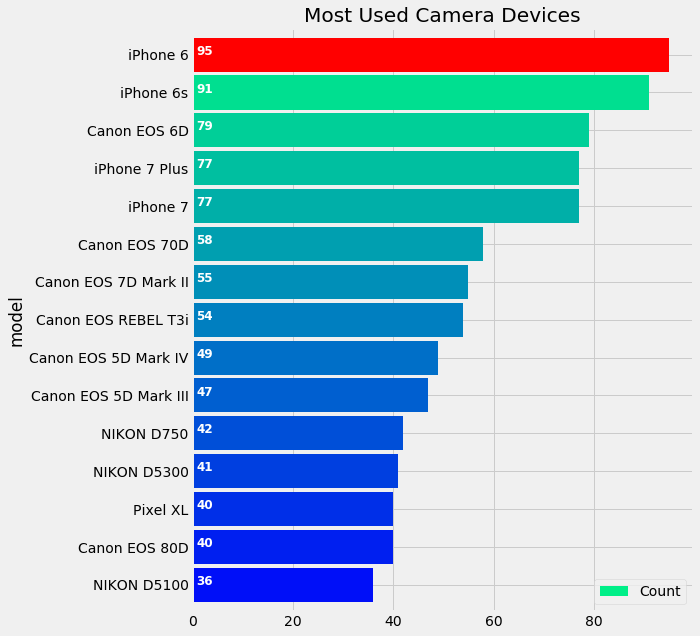

In [10]:
Query1="""
Select model,count(Distinct user) as Count
From (
      Select model,user 
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      
      UNION ALL
      
      Select model,user 
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      
      UNION ALL
      
      Select model,user 
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      )
Group By model
Order By Count DESC
"""
model_count = bq_assistant.query_to_pandas_safe(Query1)
ax=model_count[1:16].plot(x='model',y='Count',kind='barh',width=0.9,color=sns.color_palette('winter_r',15))
for i, v in enumerate(model_count[1:16].Count.values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.gca().invert_yaxis()
ax.patches[0].set_facecolor('r')
fig=plt.gcf()
fig.set_size_inches(8,10)
plt.title('Most Used Camera Devices')
plt.show()


Wow!! Iphone 6 is the highest used device for capturing photos, also higher as compared to DSLR's. We can see that Iphones are competing well with the DSLR's. A prime reason for this is surely the compact size and its great camera quality. 

Coming to the query, we first extract the user and model columns from the files, then groupby the data extracted using the models and get a count of users using the devices. We then sort the data using the Count column in descending order.

Now let's check the most used camera's by the is_mobile column i.e lets check the most famous mobile camera and DSLR camera companies.

In [11]:
Query1="""
Select make,count(Distinct user) as Count
From (
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      Where is_mobile=True
      UNION ALL
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      Where is_mobile=True
      UNION ALL
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      Where is_mobile=True)
Group By make
Order By Count DESC
"""
makemob_count=bq_assistant.query_to_pandas_safe(Query1)
Query2="""
Select make,count(Distinct user) as Count
From (
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      Where is_mobile=False
      UNION ALL
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      Where is_mobile=False
      UNION ALL
      Select make,user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      Where is_mobile=False)
Group By make
Order By Count DESC
"""
makecam_count=bq_assistant.query_to_pandas_safe(Query2)


Above we use 2 seperate queries to get two separate dataframes for top mobile cameras and DSLR's. The only difference between the above and previous query is that we have added a **WHERE** statement, which is used to filter out mobiles and DSLR's using the **is_mobile=True/False** condition.


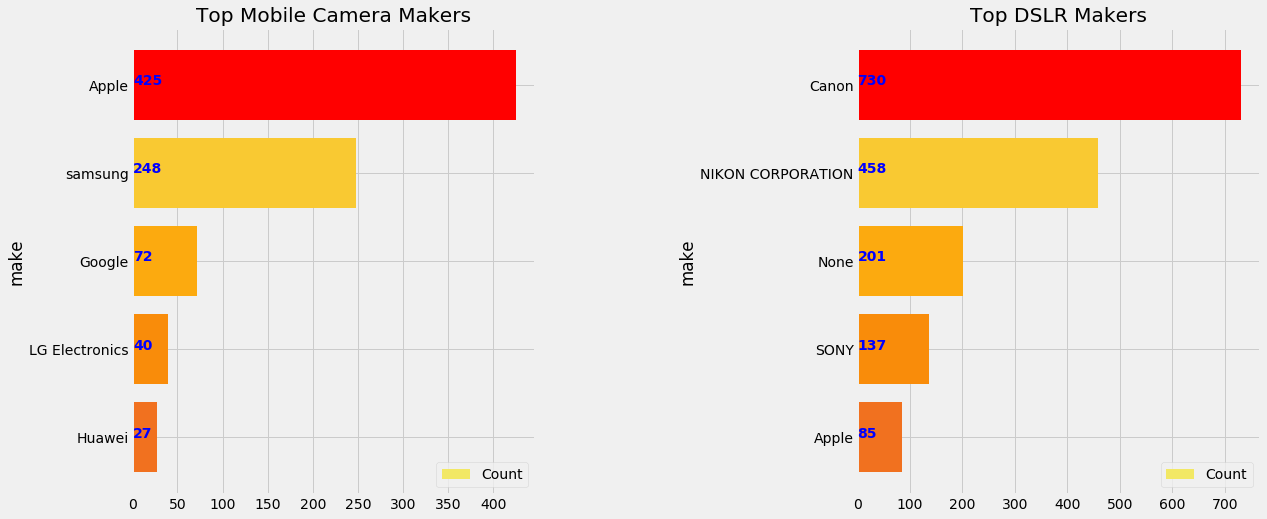

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))
ax1=makemob_count[:5].plot(x='make',y='Count',kind='barh',width=0.8,ax=ax[0],color=sns.color_palette('inferno_r',15))
ax[0].invert_yaxis()
ax1.patches[0].set_facecolor('r')
for i, v in enumerate(makemob_count[:5].Count.values): 
    ax1.text(.8, i, v,fontsize=14,color='b',weight='bold')
ax[0].set_title('Top Mobile Camera Makers')
ax2=makecam_count[:5].plot(x='make',y='Count',kind='barh',width=0.8,ax=ax[1],color=sns.color_palette('inferno_r',15))
ax[1].invert_yaxis()
ax2.patches[0].set_facecolor('r')
for i, v in enumerate(makecam_count[:5].Count.values): 
    ax2.text(.8, i, v,fontsize=14,color='b',weight='bold')
ax[1].set_title('Top DSLR Makers')
plt.subplots_adjust(wspace=0.8)

### Camera Aperature

In [13]:
Query="""
Select make,aperture_value
From (
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      Where is_mobile=False
      UNION ALL
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      Where is_mobile=False
      UNION ALL
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      Where is_mobile=False
      )
"""
Query1="""
Select make,aperture_value
From (
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      Where is_mobile=True
      UNION ALL
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      Where is_mobile=True
      UNION ALL
      Select make,aperture_value
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      Where is_mobile=True
      )
"""
aper_cam=bq_assistant.query_to_pandas_safe(Query)
aper_mob=bq_assistant.query_to_pandas_safe(Query1)
aper_cam=aper_cam.dropna()
aper_mob=aper_mob.dropna()

Text(0.5,1,'Aperatures for Mobile Camera')

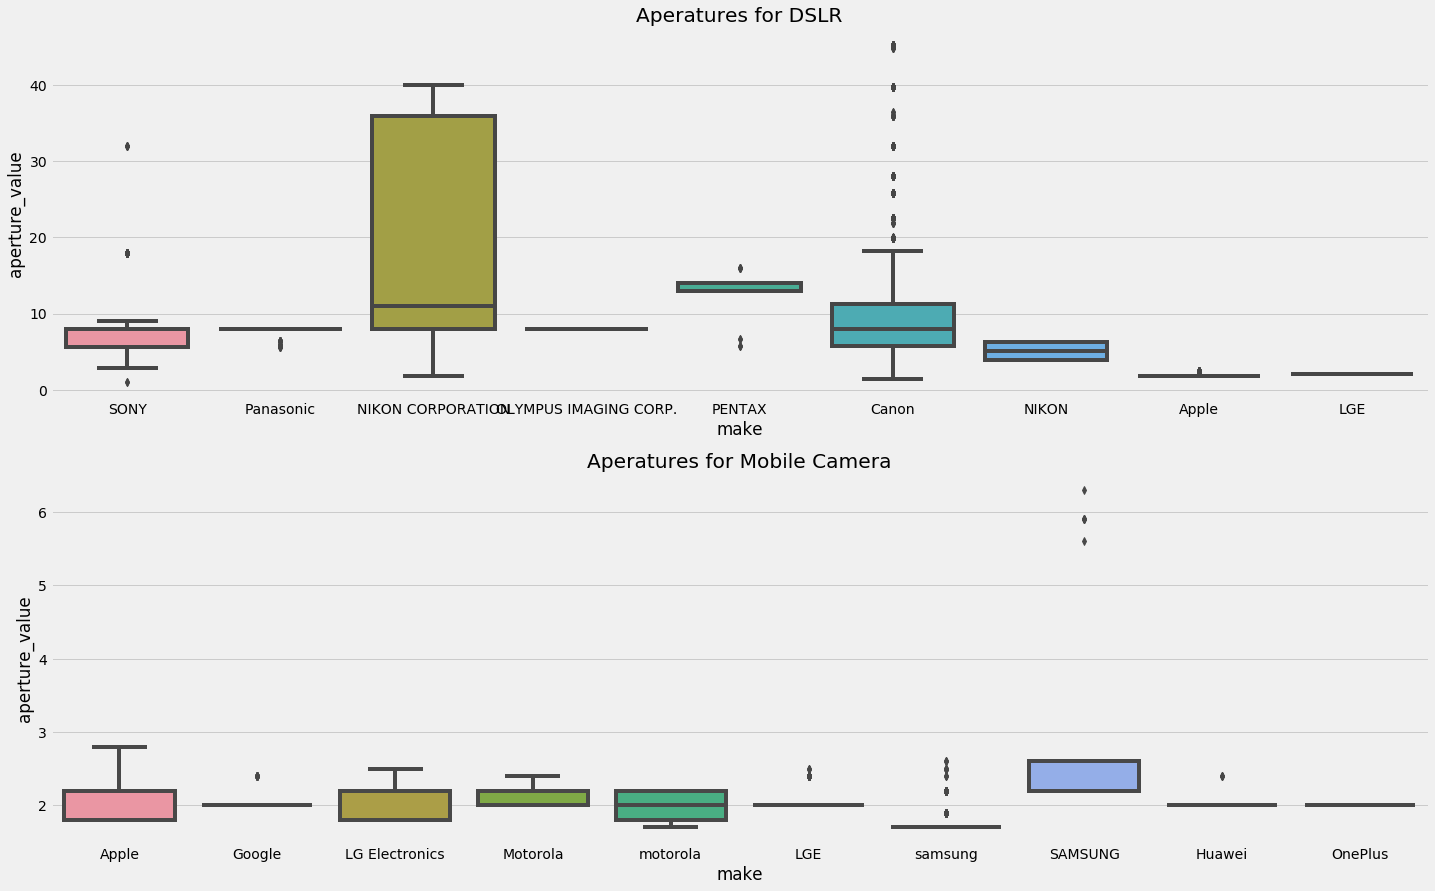

In [14]:
f,ax=plt.subplots(2,1,figsize=(22,14))
sns.boxplot('make','aperture_value',data=aper_cam[aper_cam['make'].isin(makecam_count['make'][:10])],ax=ax[0])
ax[0].set_title('Aperatures for DSLR')
sns.boxplot('make','aperture_value',data=aper_mob[aper_mob['make'].isin(makemob_count['make'][:10])],ax=ax[1])
ax[1].set_title('Aperatures for Mobile Camera')

It is evident that the aperature's of the professional DSLR's have a very high range as compared to mobile camera's. Some DSLR's aperture are even more than 40, whereas the range of aperature for mobile phones is generally between 2 and 3, with a few exceptions going above 5.

### Labels

Let's check the labels or keywords that the Computer Vision Algorithm from Google generated by processing the image.

In [15]:
Query="""
Select vision_labels 
From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
"""
labels=bq_assistant.query_to_pandas_safe(Query)
list1=[]
for i in labels[labels['vision_labels']!=''].vision_labels.str.split(','):
    list1.extend(i)
labels=pd.Series(list1)

In [16]:
insta=b'/9j/4AAQSkZJRgABAgAAZABkAAD/7AARRHVja3kAAQAEAAAAZAAA/+4ADkFkb2JlAGTAAAAAAf/bAIQAAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQICAgICAgICAgICAwMDAwMDAwMDAwEBAQEBAQECAQECAgIBAgIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMD/8AAEQgCCAJsAwERAAIRAQMRAf/EAK4AAQACAgIDAQEAAAAAAAAAAAAKCwgJBgcBAwUEAgEBAQEBAQAAAAAAAAAAAAAAAAMCAQQQAAAGAgECAgMJCwYNAgUDBQABAgMEBQYHCBEJEgohEzkxItIUFZe3eBpBVJSV1VZ2ttdYuHEyIxZXd1FhsUKztHU21hc3OBkkWVJiMyWYQzRENSYnGCkRAQEAAgIBBQEBAQEBAAAAAAABMQIREiFBYXEyE1ED8IEi/9oADAMBAAIRAxEAPwCfwAAAAAAAAAAAAAAAAA4pm+d4PrPGLXN9j5limv8ADKFj41eZdm+RVGKYxTRfESPjNrf30yBVVzHiUReN51Cep+6A0C8sPNE9pfjGqzp8d2/f8nM2gIeQnG+OuNrymmOW2chtDT+x7+VjWu1xzfY8K1wrKe4hK0qJpRGNTW1m76xpy1t5vjbXJzmRxu4+6N4i691rrbcG/dWavv8AKNp5pkWf50rF82zWkx61sKesxRGCY9jl6zBsHDY9e7csJcJJqJRdUjvTxyzN+bxwnZDCgA1rd37lttTgr25+SnKzScPDLDZ2o6bCLHF4ewaa0yDEH3cg2hhGIWSLiopb/F7OWj5GyGQbPqpzHq5BIWrxpSbauzzeHLeJygPfbHu7J+YnCn5m9qft+G+if6O2dB+bm7pmzt66W1tkOE8N2KDYW2dc4PePVmodnx7JmnyzMKahs3a+Q/vaUwxObhT1m0tbTiEuERmlRF0PnQ7rLEYVAGC3c05H7B4hcBuVXJrVMXGJuxdLalvM5xCJmlZYXOKyLitehpZavKuquKCwmwVIeV4kNTI6+vQ/H6Oh9nm8OW8TlXvfbHu7J+YnCn5m9qft+G+if6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6H2x7uyfmJwp+Zvan7fg6H6Bece7sZGR/1E4Un0P3D03tXof+I+m/iPoYdD9HZGIedB7jlY+yea8euG+WRCWRyW6fFtx4lLca8RmpMeU7uXJI8dw0eglKjukXu+E/cHOnu7+ns2R6L87FquzdhQeSfCLOcPQp1pqdkWmNm0meMpbM0k9LaxbM6PAX2ySRmZNfKjyvR08Z9fQ6H6ezfXxX8w/wBpPlnJraXE+VGO6tzG0cbYYwrkHBlaatvjbrZuIhNX2UGjALGWr+alEO5k+Nw/CjxK9AzdbGptrW6etsq65gRLWosIVrWT2ESYNjWymJ0CbGdLxNyIkyK47HksOJ9KVoUpJl7hjjT9oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjk+azIj7LPIDqXubF4+mX+I/+cmIl1L/B6DGtcsb/AFVOIqizu7XftI+Bn1u+Pf0pYwOXDuuZ8rtYRegAaOPMk+xR5y/orq76eNWjuuWd/qqAhZBkXw+/7tuLf1i9JfSXjIOzK85EHoAGprvseyA7g31c8t/09cOzLO31qmgFkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGw/hb3Wuffb/t4cvjLyOzvE8ZYfbem6tvbBeZaiuENmfVqw1xkp2ONsuuJUafjUNmLOQkzJD6OpjlkuWptZhOH7a3m9uO+8ZGP6v7gWGw+MmxZpRa9rc2J/Kd3oO8sV+qZ9dfwZLljl+rvjTyupLfXb1jSfEp+ZGQRdcXT+KTeXKYfiuV4vnOOUuYYVkdFl+JZJXRrfHsnxi2gX2P3tVMbJ2JZU9zVvyq6ygSWzJTbrLi21l6SMxht98AAAAAAAAAAAAAAAAAAAAAAAAAAAGMnLrmDx+4N6TyTf3JHPYGC4DjxIixiWXxzIctyKWlz5Hw3CaBlRT8lyy8ebNEaIwXoIlOuqaYbddQk5ct481kyk/ElKjI0mpJH4T6dU9S69D6GZdS/xGDr+gEcrzWfsWeQP94nHz6ZcQGtcsb/VU4CqLO7td+0j4GfW749/SljA5cO65nyu1hF6ABo48yT7FHnL+iurvp41aO65Z3+qoCFkGRfD7/u24t/WL0l9JeMg7MrzkQegAamu+x7IDuDfVzy3/T1w7Ms7fWqaAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABuT7V/e/wCZPavy2HC11kj2z+PNhZFJzXjdntpNfwiwbkOpVPtMImmUuZrbL3EEZpnV6DjSHPCc2LLSlKSzdZflrXa6/C0f7b/c/wCK3dC0vG2zxzy7/wC9VTEGPs3UWSORIWzNUX8pszOqymlZfeTJrJLja/iFtDU9W2DaD9W6TqHmWp2WLSy4bEhx0AAAAAAAAAAAAAAAAAAAAAAABhpzy526A7dXHLMeSvIjIzqsWxxsoOPY1Wqiv5jsfMprbnyHguD1MiRH+VL+3dbMzM1Ijw4rbsqS41HZdcT2Tnw5bJOaqS+493SuSHdP5PQtu7suXafCqTIkwtOaVp7CS7g2pcUlWcQkQKthwmU22TWbMZldvcvNplWMhBdCZjNx4zFZOEbeaufi9wv5C/yCK7yAjleaz9izyB/vE4+fTLiA1rljf6qnAVRZ3drv2kfAz63fHv6UsYHLh3XM+V2sIvQANHHmSfYo85f0V1d9PGrR3XLO/wBVQELIMi+H3/dtxb+sXpL6S8ZB2ZXnIg9AA1Nd9j2QHcG+rnlv+nrh2ZZ2+tU0AsgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAye4gcxOQnBTemJciONOfWGBbFxOQklKaNyTj2V0TrzLlrhub0Jutw8nxC9bZJEqG/90kutKakNtPN8sly7LZ5i2r7PPd90f3aeP6c4xNMHA99YFHrqzfWjJFk3JtMOvJDJJZyfGVPLTNvdZ5Q+24qssDQS2nEuRJPhkMq8crOL7La7Tae7b2ONAAAAAAAAAAAAAAAAAAAAADrvbe2NeaJ1jnm5dtZVV4RrTWWLXOZ5tld0+TFdSY9RQ3Z1hMdMiU4+76prwMsNJW/IeUhppC3FpSYVAHec7tG0u6/yis9hWbtri/H7Xsm0xzjrqV+SZR8WxFchCZGV5BGZdXDlbEzo4rcq1kF4/UIJmE0tTEVtSrScT3Q227X2al8c/3hov8AbNX/AK8wOsr6ovcL+Qv8gg9LyAjleaz9izyB/vE4+fTLiA1rljf6qnAVRZ3drv2kfAz63fHv6UsYHLh3XM+V2sIvQANHHmSfYo85f0V1d9PGrR3XLO/1VAQsgyL4ff8Adtxb+sXpL6S8ZB2ZXnIg9AA1Nd9j2QHcG+rnlv8Ap64dmWdvrVNALIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsLVOp9mbz2HiepdO4Lk+ytl51bR6PEcJw2ol3mQ31pI6mmPBr4TbjqkMtIU686rwsx2ELddUhtClFx1MD4l+TJ5S7Gx2nyvlvyNwHjo7ZMsy3tbYLjr24s5q2XU+I4d/dt3uLYRV2jXUvEiDKuWfuetIxm7z0bn+d9Wef2JLR/7/ADtb5kcQ/wCPBzvXfz9z7Elo/wDf52t8yOI/8eB3p+fufYktH/v87W+ZHEf+PA70/P3PsSWj/wB/na3zI4j/AMeB3p+fufYktH/v87W+ZHEf+PA70/P3PsSWj/3+drfMjiP/AB4Hen5+59iS0f8Av87W+ZHEf+PA70/P3PsSWj/3+drfMjiP/Hgd6fn7uOZZ5JDXq6OYWDc/8zj5L4SOvcyzQ9JMo/ER+lMxmn2RBn+FRegjQ51L3eh+4Hc/P3RiO512JedPa2b/AK5baxmm2ZoSXaM1VZv/AFM5ZXWERZkxaG62uzevnQIN/r61sHHCaZKwYKDJkf0UaXIX6BqbSsXWz4aYRpkAAGX3Bbm3vHt7cltf8ntA3qqzL8Lmkzc0Mt6UnGthYXNejnkuvszhRnWlWOM5JFYSlxPX1kaQhmUwpuSwy4jlnPh2Wy8xcdcA+cemu4nxb1tyl0jOUeO5tAOLkWLzJDL9/rrPatDLWW6+yZLJIJFvjtg54UueBDc2G4xLaI2ZDZnKzi8Ly8zlmYOOgAAAAAAAAAAAAAAAAAAAK8Lzc3djlZ3n8Ttg6SyQ04NreZS5fyltaqQk28n2N6pi4wzVbklhwydqcChvtWloyZqQ5cvxm1kh2tUR00nqlvfRB4G032cc/wB4aL/bNX/rzAC+qL3C/kL/ACCD0vICOV5rP2LPIH+8Tj59MuIDWuWN/qqcBVFnd2u/aR8DPrd8e/pSxgcuHdcz5Xawi9AA0ceZJ9ijzl/RXV308atHdcs7/VUBCyDIvh9/3bcW/rF6S+kvGQdmV5yIPQANTXfY9kB3Bvq55b/p64dmWdvrVNALIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0d8rl2nsN4hcRMU5l7JxiHO5QcrsUhZZWW1nEJ2frDRd4SLDB8Rx9UllLlZOziqNi8uXmvCuQmREir6ph9Vy2vN4W0nE59UqcZbAAAAAAAAAAAAcK2RrjA9wYFl+rdoYnR51rzPsfs8WzLD8kgtWVHkOP3EZcSwrLGG8RocZfZcPoZdFtqIloUlaUqIKZnu6cEne3Hz+31xdhPzZ2DY7excs1Ja2DhvzbLU2dQ28jwgp0o+nx20pK+YdVOfIkk9OgPLJKSPwlaXmcobTi8Naw6yAACR95bDuwzO3dzHrtUbPyRULijymuaLCdlIsZKyp9d5+878mYBt1klmbNfHr50wq29dLwIXTyTfd8aoEdKc7TmN6bcX2WwxGRkRkfUj9JGXpIyP3DIxJYAAAAAAAAAAAAAAAAAAGAnc/5uY728eDe/eVN0qA/dYJiL8DW1FYKP1OU7YyhaaDXWPqZR/TSIsjJZzL80my8TddHkO+hLZmXZObw5bxOVLFnmc5bs/N8w2Rnt7OyfOM/ye9zPMMjs3Cdsb7J8ms5Vze281wiSlUqxs5jrq+hEnxL9BEXQhZDLiYOPs45/vDRf7Zq/wDXmAF9UXuF/IX+QQel5ARyvNZ+xZ5A/wB4nHz6ZcQGtcsb/VU4CqLO7td+0j4GfW749/SljA5cO65nyu1hF6ABo48yT7FHnL+iurvp41aO65Z3+qoCFkGRfD7/ALtuLf1i9JfSXjIOzK85EHoAGprvseyA7g31c8t/09cOzLO31qmgFkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABe36Jq6+k0hpulqYjNfVVGqteVdZAjIJEeFXwMRqIkKIwgvQhmNGaShJfcSkhB6Jh2qDoA+LkOSY7iNRMyDK7+lxihr0E5Pu8htINLUQW1KJCXJllZPxocZBrUREa1pLqfQBh3P7mPbpq5sqused3EGFPhPKjy4kjkXqVt+O8jp42nUKyzqhaevpId4rnM/sfk/8AKB23P39+Hn/5Hak/4sDinaf2H/lA7bn7+/Dz/wDI7Un/ABYHFO0/sP8Aygdtz9/fh5/+R2pP+LA4p2n9jIbU3InQO+obtho/d2pdwQmGiekSNY7ExHOm47JqSgnZJ4zb2Rx2zUoiI1+Eupl/hHHeZcO4wAAAVkfnOIUSN3O9IyY8ZlmRYcJddSJzzaCS5LfZ3Vv+E08+ovS443EjNtkZ+4hBF9wU0wl/plEXG0wAAAFtr5azuJvc+O3Ph1Pm90q03txZfrtFbUdlyfX2t9UVNW27q7PpfjM33DyjDWUxJD7hmqTbVM5fuGRCW04q+l5nukHjLQAAAAAAAAAAAAAAAAAr2fOf81X7zZPHDgPi1ur5IwSjf5DbbhRX1+pk5XlfyjiusamxQgyQUnH8ZhW071SuvVu7YcMvQgxTSeqX+l9EGEbTAH2cc/3hov8AbNX/AK8wAvqi9wv5C/yCD0vICOV5rP2LPIH+8Tj59MuIDWuWN/qqcBVFnd2u/aR8DPrd8e/pSxgcuHdcz5Xawi9AA0ceZJ9ijzl/RXV308atHdcs7/VUBCyDIvh9/wB23Fv6xekvpLxkHZleciD0ADU132PZAdwb6ueW/wCnrh2ZZ2+tU0AsgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAL37Tv/AEj1Z/dzhH6s1gg9Ew7GB1rC7tPc91T2p+KV5v8AzyAjL85u5x4bpLVLNgiun7I2LLiPSo0R+X4HnqzFMfhtKnXM5LazjxGybbSuS/Hac7JzXNr1nKpz52dzfmf3Gdg2Oc8ndy5Hk1W5Oek41q2nmzKLUWBxFOmuNXYjgMSUdPFOM2SUKmyEybOV4CVIkvL98KySYQttywEHXAAAAHPNa7S2VprMqTYmpM+zDWmd45MZsKLMMFyK1xfIqqWwsnG3odtTSoc1n0l0Ukl+FaTNKiMjMgdWT/lvu/5k3P03+GXMG1rXuVmI4zIvtbbMYiRahvfuHY/HSq/iXldDbj1kXaeKQyKY+qI20zb1qXZJMtuxJK3p7a8eZhXTbnxcpdIw2AKyzzn3tNNC/Ue1/wDTnyGFNEv9Mohw2mAAAAk1eVJ5nyuMvc+xrT11ari645h4xO01cQ3nvBAb2JAJ3KNT3JtqWlCrFd3Bk0jH3TK9WREZ9BnaeG9LxVq0JLAAAAAAAAAAAAAAAAAClg7wHJiRy77mHMreXx5ywpLvdmVYrhUhUj4w2rX2tH0a4wRcdfQkoYk4tisV8kF6Em6ZdT907TCG15vLW0OsgD7OOf7w0X+2av8A15gBfVF7hfyF/kEHpeQEcrzWfsWeQP8AeJx8+mXEBrXLG/1VOAqizu7XftI+Bn1u+Pf0pYwOXDuuZ8rtYRegAaOPMk+xR5y/orq76eNWjuuWd/qqAhZBkXw+/wC7bi39YvSX0l4yDsyvORB6ABqa77HsgO4N9XPLf9PXDsyzt9apoBZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXv2nf8ApHqz+7nCP1ZrBB6Jh2MDqsR84rv/ACbYPcnwTRL054sK496DxJVTUetdOMjMNrTJ2XZVd+qUZMpk2FFHo4qjSRn4IKeqvuFTSeEt754RKRtMAAAAAAGYvb13dlPG/nPxK3dh0l2Pea+5AawtfAyo0fKVNKyquqMooXjSpJnDyPGLGZXvp6l4mJKy+6OXzHZ4q7/EXoAFZZ5z72mmhfqPa/8Apz5DCmiX+mUQ4bTAAAAdgan2PkWndp6225iMlyHlerc+w/YmNS2XVMuxr/Cshr8kqHkOo9+2pufWtn1L0l0HHceV57p3ZVHufUerNw4w6h7G9r65wjZOPvNrJxt2kznGqzJ6paFkZktKoNo2ZH1PqIvRMOxwAAAAAAAAAAAAAAAY38xtrJ0VxI5QbqVIVEPU3HzcexmpKFeBxmThuvchyCKttfpNLhSYCPCZdT8XToRhMlwo0pMl+ZJkS5Tq35Mp92TIfcPxOPPvuKdedcV/nLccUZmf3TMXeZ6AAB9nHP8AeGi/2zV/68wAvqi9wv5C/wAgg9LyAjleaz9izyB/vE4+fTLiA1rljf6qnAVRZ3drv2kfAz63fHv6UsYHLh3XM+V2sIvQANHHmSfYo85f0V1d9PGrR3XLO/1VAQsgyL4ff923Fv6xekvpLxkHZleciD0ADU132PZAdwb6ueW/6euHZlnb61TQCyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvftO/wDSPVn93OEfqzWCD0TDsYHVUR5sX2zO4P7o9B/RzWiuuEd/sjZDTAAAAAAAO2tBf9dtK/3ta4/XGmB2ZXtQg9AArLPOfe000L9R7X/058hhTRL/AEyiHDaYAAAAAuFPLq7df3P2auEWQy5T8ydiuBZLqeW7IWa3Up1FsPLtdVrPUyJRNsUuORUI6/5hF7pdDEbl6NcT4bsBx0AAAAAAAAAAAAAAGljzEmyXtV9mPnbkEfwevvNa41rZPrHFNJNnbWzcG1jO6KQpKlLKvyx00p9xSuhGRkZkOzLm2L8KeIWecAAH2cc/3hov9s1f+vMAL6ovcL+Qv8gg9LyAjleaz9izyB/vE4+fTLiA1rljf6qnAVRZ3drv2kfAz63fHv6UsYHLh3XM+V2sIvQANHHmSfYo85f0V1d9PGrR3XLO/wBVQELIMi+H3/dtxb+sXpL6S8ZB2ZXnIg9AA1Nd9j2QHcG+rnlv+nrh2ZZ2+tU0AsgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAL37Tv/SPVn93OEfqzWCD0TDsYHVUR5sX2zO4P7o9B/RzWiuuEd/sjZDTAAAAAAAO2tBf9dtK/wB7WuP1xpgdmV7UIPQAKyzzn3tNNC/Ue1/9OfIYU0S/0yiHDaYAAAAAtQPKGZE7d9nykrXFrUjEOSe+MdYSsjJLbUmfj2WmhozUolIN/KFq6kSS8SjLp9047ZX1x/38ShBxoAAAAAAAAAAAAAAEe3zTXsP+XP6Q8aP4pNNjsy5ti/CpNFnnAAB9nHP94aL/AGzV/wCvMAL6ovcL+Qv8gg9LyAjleaz9izyB/vE4+fTLiA1rljf6qnAVRZ3drv2kfAz63fHv6UsYHLh3XM+V2sIvQANHHmSfYo85f0V1d9PGrR3XLO/1VAQsgyL4ff8Adtxb+sXpL6S8ZB2ZXnIg9AA1Nd9j2QHcG+rnlv8Ap64dmWdvrVNALIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC9+07/wBI9Wf3c4R+rNYIPRMOxgdVRHmxfbM7g/uj0H9HNaK64R3+yNkNMAAAAAAA7a0F/wBdtK/3ta4/XGmB2ZXtQg9AArLPOfe000L9R7X/ANOfIYU0S/0yiHDaYAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAPs45/vDRf7Zq/8AXmAF9UXuF/IX+QQel5ARyvNZ+xZ5A/3icfPplxAa1yxv9VTgKos7u137SPgZ9bvj39KWMDlw7rmfK7WEXoAGjjzJPsUecv6K6u+njVo7rlnf6qgIWQZF8Pv+7bi39YvSX0l4yDsyvORB6ABqa77HsgO4N9XPLf8AT1w7Ms7fWqaAWQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAF79p3/pHqz+7nCP1ZrBB6Jh2MDqqw83HiVxjveCyu7sY7jVfnugdIZNj76mloblVtfUWuFSlNuK946bV1icpCvD/N6ERiuuEd/sjFDTAAAAAAAO8+MFBbZXyW484vQw3bC8yPeWpqKmgMpUt6baW+e0ECvitJQlSlLkSpCEF0Iz6mOXDsyvURF6ABWWec+9ppoX6j2v8A6c+Qwpol/plEOG0wAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAfZxz/eGi/wBs1f8ArzAC+qL3C/kL/IIPS8gI5Xms/Ys8gf7xOPn0y4gNa5Y3+qpwFUWd3a79pHwM+t3x7+lLGBy4d1zPldrCL0ADRx5kn2KPOX9FdXfTxq0d1yzv9VQELIMi+H3/AHbcW/rF6S+kvGQdmV5yIPQANTXfY9kB3Bvq55b/AKeuHZlnb61TQCyAAAAAAAAAAAAD7+NYplOaW0ahw7Gr/LL2a42zDpcaprG9tpbrq0ttNRq6rjSpj7jjiiSlKUGZqMiL0gNqWjOxB3b+QvxB7A+Dm5aissvTHuto1tbpypJPo9+7I2lZYm4hBkrr18B9SGe0jXXb+Nq2qfJ090HMzjPbHzfjLpuI+lKnmLXYGRZrdwzP+eh+HheH2VO4pJe56qxcSZ/dL3RzvHelZy4N5JHY8lLZ7K594TTqMurzeDaOvckS2fvPetvX+wMUN4v53vjbR9z0e6Hd38/d3zV+SP1O2iH8tdwPYcxxC0nPOr0Fjdah9snTNSYZS9nWqoi1M9EkpZvESvfdDL3o53d/P3fSsvJJ6Qce8VPz32rCj+pIvVWWk8Rs3vjHVfic9fFzmoR6kyNPRHq/EXQ/fH1Lo7n5x0tlvkjLpmItWCdwmrsJ3h941lvHiXTxDX0V6Fv0+2rx4k+Lw+kmzPp19Adz8/dhhsvyZPcRxpo3tab34t7O6EtXxWbd7BwKaok+M0oQmwwi5gm854SIiOQlHVXpWRdTHe8c/OtY26vLhd4/R6X5Ntw7ybP6thD7x2mm8pwnaTbkdg19X01WK5BMyVslpQakocgod8PTqguo72jPTZqH2bpTcmlbhzHtxan2Vqm9aX4HKbY+DZNhFmlR+LoXxHJaytkmSvAfQySZGRdSHXHWI64AAAAAAAAAAC9+07/0j1Z/dzhH6s1gg9Ew7GB1FO80z2mc0528ccO5Ocf8bmZTyF4qwb/5SwqniuS73Zuk7lbVnkdNRQ2UrkWeVYPaxCta6I2RuSoz9gy0lyS5HbVrW8XhjfXnzMqu91pxlxxl5tbLzK1tOtOoU24042o0LbcQsiUhaFEZGRkRkZCqL+AAAAAABLS8ql2q845McusZ51bHxadW8buK98q/wy4tYamYWzd+QWlpxSoxtUhsk2MDWst5N3ZS2TNEafHgxuprec9Vja8ThTTXm8+izyE1QBWWec+9ppoX6j2v/pz5DCmiX+mUQ4bTAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAB9nHP94aL/bNX/rzAC+qL3C/kL/IIPS8gI5Xms/Ys8gf7xOPn0y4gNa5Y3+qpwFUWd3a79pHwM+t3x7+lLGBy4d1zPldrCL0ADRx5kn2KPOX9FdXfTxq0d1yzv8AVUBCyDIvh9/3bcW/rF6S+kvGQdmV5yIPQANTXfY9kB3Bvq55b/p64dmWdvrVNALIAAAAAAAAOUYZhGZ7HyWqwzX2JZLnOX3klEOlxbEKKzyTIbaU4ZEiPXU1PFmWM15Rn/NbbUYCSzwr8p33LeTLVVk27IOJ8OdfTkNSVPbZedu9oPxHUE4n4lqvGXnZtfKNKi8TN1Op3Wup+JBqSaBi7T0bmluUrTiX5SXth6CRAtt2M7H5dZhHLxyHtlXz+GYB68ieSSoGAa/lVT5R+i0K9VY21oRrR7vhM0Hm7WtzSRIX0jxc428a6WPj3H3Q2o9MVEaOcVuJrXX+MYgpxlR+JaZUqlrYkuap1fvlqeccWtXpUZn6RlriTDvgHQAAAAAAAABwrPda662pQv4ts7AsN2JjUpLqJGP5zjFLldK8l5s2XScrL2FPhqNxpRpM/B1Mj6ANFfKvyx3aR5PNWM+s0TL435jORIU3lXHG9cwSKxKfW058YVgU2Pe63WhBtGXgbqWferV0MlGSi1NrGbprUWbmf5ODmDqpu0yfhtuDB+T2Mxm3ZLOD5e2zqPbCWmo/rVR4Jz59lr/IXvGhSUqVZ1jjhmkksmZ9Bqbz1Yv+d9EVDf3GTkLxXzeZrfkdpnY2l81hOONqothYtaY69MQ0TajlU8qbHRX3tcpDqFIlQnpEZxKiNKzIyMallwxZZl0YOuAAAAAAAvetMOtP6e1Q+w4h5l7WuCusvNKJbbrTmL1a23G1pM0rQtBkZGXoMjEHomHZQOgCOh3IvLMcAe4Hl11t6ibyHixvbIpK5+S53p6vp3sUzSzec8cm4zbWFkmPR2F5KMzU9OrZFRLlOqNyU4+szM9Taxm6S/LQXaeSQ2qVhLKl5/6+VVeuV8QVaaHyNFgcf/M+NpibHcjE9/h8Bmkd7sfn7vwfYkd0/v8Aur/mKyv9og73Pzp9iR3T+/7q/wCYrK/2iB3Pzp9iR3T+/wC6v+YrK/2iB3PzrOLiV5MfjRrvJqfK+XXJHNuQkWrfTKe1rgGMt6jwy4dZcbcaj39+u8yjMZtU6RKS6xCeq3lF7kgi6kOXe+js/wA56piWrdWa40jr3EtT6iwnG9ca1wOmjY/h+E4hVRaXHcfqIhK9VDrq+G22y2SnFqcdWfVx55a3HFKcWpR4Uc+AAFZX5z1SVdzXQ6UqSpSOD+viWklEZoM95chVESyI+qTNKiPof3D6immEv9M/+Ih42mAAAAALRjydvskrz63e7f1a1eJbZX1wlWDLQAAAAAAAAAAAAAAI9vmmvYf8uP0i40fxR6bHZlzbF+FSaLPOAAD7OOf7w0X+2av/AF5gBfVF7hfyF/kEHpeQEcrzWfsWeQP94nHz6ZcQGtcsb/VU4CqLO7td+0j4GfW749/SljA5cO65nyu1hF6ABo48yT7FHnL+iurvp41aO65Z3+qoCFkGRfD7/u24t/WL0l9JeMg7MrzkQegAamu+x7IDuDfVzy3/AE9cOzLO31qmgFkAAAAABzPXuuc/21mVBrvV2F5TsPPMpntVmOYdhlFZZJkl3PePoiNW09TGlTpbnTqpXgQZISRqUZJIzLjqZH22/J9bw2u1jmz+4lnrugcIlfFrL/kPruTV326LWEo2H0w8rypaLPDNdnJaNSVssIupyCM0uJiukZFm7/xuaf1OS4bduThXwDxRrFeKugMG1ktcZEe3zFmv+W9k5P4WkNLdyfYt6qxy+5J3weL1Lkv4s2oz9W0gj6DFtuVJJMM3Bx0AAAB/DjjbKFOuuIabQRqW44pKEISXuqUtRklJF/hMB1Vlu+tGYD/v1ujU+F+gj/8A7t2Lh+OehS220n/94uIfoNx5CS/xqIvdMgc5jpe27hPAui9X8rc1OKUI3XHGmyc5BapWo3GunrEGlrK3FIUjr6epF6Q4pzHqq+4fwGulPIrObHFCUqOSFPEnkHqls0JcNRIP+mytvxeI0H7nUOKcx3LifIXQWeOE1g28dP5m6rxeFvE9l4XkTivAfhX0RT3UxR+FXoP0egwOY7cZeZkNoeYdbfZcLxNusrS42tPudULQakqLqX3DB17AAAAAHS+9+Oeh+T+Bz9Y8h9Ra/wBy4FYk56/Gdg4zWZHAYecbNo51aqew5Jp7NtB9G5cRxiS3/mOJMCyXKGx3GvJ060y2PebH7bmyX9aZKluXPLj5uC2nX2A2r/8ATPprsL2S4iXlGJOOGaW2mbdNtHNXTxSY6Oplub/1O/5/xBf5S8POTXCrZEzU3KLTWa6dzaOb6okLKaxTdXkEKO76pVtieRxFyseyylWoy8MuulSWD8RF4iP0DcsuE7LPFY1DrgAAAC3h8ur3CMU539t/UFc/exX93cZ8ZxvQ+6cdckNHbsPYdVpp8BzRyORpfeqs8wyrjyEyTSSF2TE5kjUphRnLacVfW8xvjGWgAAAAAAAAAAAHreeajtOvvutsMMNreeeeWltplptJrcddcWaUNttoSZqUZkREXUwFPB3/APm5jXPPug772tr63Zv9T4Iqm0dqm8iOLdgX2I6wakV03JKtxXodqMpzSZbWUJwiInYctpfQjMyFdZxENrzWl4aZAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAB9jHjJN/RqUZERXFYZmZ9CIimsGZmf3CIgF9S0tDrbbja0uNuIQttxCiWhaFpJSVoUkzSpKkn1Iy9BkIPS/sBHK81l7FnkD/AHicfPplxAa1yxv9VTgKos5+2JKjQu45wRlTJDESMzy649qekyXm2GGk/wDNPFy8TrzqkNtp6mRdTMiHLh2Znyu3RF6ABo48yT7FHnL+iurvp41aO65Z3+qoCFkGQHE2wgVPKfjRaWk2JW1lbyA01YWNjPkNRIMCBD2LjkiXNmyn1tsRokWO2pbji1JQhCTMzIiHHZlehIWhxCXG1JW2tKVoWhRKQtCiJSVJUkzSpKkn1Iy9BkIvQ/oBqf76TD0jtBdwhuOy6+4njdmj6kMtqcWlmMcKTJeNKCMyajx2luLV7iEJNR9CIx2ZZ2+tUzYsgAAAA3/dpTy8/MDueS6XZNnGf488TlzI65+8s1p33bHM4CHyTNh6cw156BMzSWbaFIKydci0jC+pHJddQcdWbtJ8t662/Cyk7evag4UdszBmsZ406rgRcxm17MPMt1ZemLkm4c7dR1U8q6y96Ky5W1brqvEmrq2oFU2ZEaY/j6rVO23KskmGyIcdAABqo5h97LtmcGzsazd/KPB5OcVqTJ7V+sXnNp7GTI6EaIc3HcLK0Tj8lzxJ6fKr8BBEolKUSOqi7Ja5dpEZDk/51eghvz6jhxw8nXbaVvtQc55EZamnYURGj1Ek9d6+cnyXUrLxdUKyFlSfQfp9JDXT+sX/AE/jQfvzzQHeI3k5Mj1vIiq0bRSzkIKk0bgGLYo6zHec8bbTWU3MLJc1Zdjo6JS81ZNOH6ep+ka6xm77VqZ2jzl5n7slTpm2+V3IjYblmRlPayrcOe20KUlSlqUl2ukXqq80mpw/R6oi9I7xGebcsXpEqVKcN2VJfkuqM1KckPOPOKUo+qjNbilKM1H7vp9I649AAA9rT77CycYedZcL3FtOLbWX8ikGSiAZI6z5m8u9MyIMnU/J/f8ArpdYsnILWH7dzyiiRlkXhI24EC9Zg9CSXTobZkOcR3mtrmh/Mz94zRbkdlzlArctKwlKPkTemFYpn3rEE6Ti/W5Kmtqc4dccIvD4l2qjSn0J6Dl1jXfZvo4yedZl/GYFTzD4cRTiqVHam5xx3zB5t5tKnUIflHrvYS3kO+pY8SzSjIk+sV6EpQXu5un8an+n9SaOHffj7XHNt2rptV8nsVxDPrXwNsav3WR6kzlcxaWj+T4DGVOx8eyOb43iQSKmxn+NRH4DURdRmyxqbStv7bjbzbbzLiHWXUIcadbWlxtxtxJKQ42tJmlaFpMjIyMyMjHGn9gADHXk7xL44czNYWmneTuocN3BgFml001OVVqX5lNNcQSE3OLXsZUe9xS+Y8JG3OrpMaUjoREvp1IdlswWc+Kr1e7l5UXd3GJjKd78AJOSci9F16J13eacnttTt8a3qmjVIfVSIgsx2Nt4/XsdfTDYZu2m0l4osrwuSBubf1LbTjzMIe0qLJgyZEKbHfiTIj70WXElMuR5MWTHcU0/HkMOpQ6y+y6g0rQoiUlRGRkRkNpvQAAM2uAncD5Jdtzf1LyD41Zammv4zJVGXYlcIkT8F2XiLryHp2H51QtSIxWdU+tsnGXW1tTIMlKX4zrTqSUOWS5dls8xYkcL/Ns9t3fmM0MHkpJyziFtVyMwzkFblNJdZ3q9yxSwRypOObBw+pmzU1bjyVGhNrWVzrZKJHV0yNZzutVm8rZQz38ezq80h1HP/RSUuJ8SSenZJHdIv/nZfx1t5tXo9xSSMc4rvbX+vZ/57Ozv/wC4Bob8Z3/5ADinbX+n/ns7O/8A7gGhvxnf/kAOKdtf6f8Ans7O/wD7gGhvxnf/AJADinbX+n/ns7O//uAaG/Gd/wDkAOKdtf6f+ezs7/8AuAaG/Gd/+QA4p21/p/57Ozv/AO4Bob8Z3/5ADinbX+n/AJ7Ozv8A+4Bob8Z3/wCQA4p21/rhWdeYk7NWBUNhey+cWusl+IRvjJU+DUWe5hfT/SaSYr66mxSQb8lRl/MNaOhekzIg607a/wBQ9+8z5p/O+YOG5dxi4K4/lWktCZZBmY/sHbeTOs1249n4/L9ZHsMdo66ply4ut8OuYZm1M8MqVa2Edw2lLiNKeYd3NePNY2358TCHcNpgAAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAPJGZGRkZkZH1Iy9BkZe4ZH9wyAWJ3an82XxbgcbcA073Cl55r7cmqcWo8KRtfHcRsc7xDbNLjtcirqchtWMfKRkGN5s5Xwmk2TbkR2FLk9ZDT6DdVHandb6K67zjitpf2qTsw/vBZz8x+0v+HRzrs131RiPMbeYQ0V3BdMYlw64ZNZdb6nczGp2HuHaWW49LxFOUT8X+OliODYpj9ksrlymh2Un5TnzZjMY3JMeK2wg0IdWrWuvHmsb7S+IhuDab9UGdNrJsSyrZcqvsa+VHnQJ8GQ7EmwpsR1D8WXElMLbfjSoz7aVtuIUlaFpIyMjIBYb9rXzc2hHdLYrqjuSRs3w3beBUFbj6d74njk/OsY2zDqIbUKNe5dTU/rclxrPJjTBKnrajS6+dINT6VxjX6hM7rfRWbz1bWftUnZh/eCzn5j9pf8ADo512a76o2fmH/MYaH51cdo/CzhM3mdxrrMclx3KN37Wy7HpmHR76sw62Re43r7EqCweTdSYbuUwIVnYTpjEZPWCwywhwnHVp1rrx5rG20s4iFiNpgCwQ7Sfm0dGYpobX3H/ALjFRnWM5zq7GKfCqPkBhWPv5tjuf45j0SLUUMnPcernf60UWZx6thtuZMisWEWycaVIX8WcWps53X+K67zjy3FF5qTsw/vB5yX8uj9pf8ODnXZrvqjsd8TzRmuuWGgticNOCOKZnFwTakI8W2xvnYFazjczIMEkfF3rnEdeYaqRLtoMTJyScOwsbT4s+cE3mWoiTeJ9Gprx5rG2/M4iEYNpgD7WOY3kOYX9LimJUVvk+UZHZwqXH8dx+tmXF5eXFlIbiV9VUVVezInWNjOlOpbZZZQtxxaiSkjMwFgX2UPKpUGGMYhyg7nuPwsnzB2PByHBuI7zjUzGcUcdJqXBsd6SY61x8myBhPQzxthaq2Kv3s5yUvxxWZ3b0iuunHm5Tkq2trqWugU9PXwqmoqoUWtq6utisQa6troLDcWFAgQYrbUaHChxmkttNNpS22hJJSREREMKP2gPzy5cWBFkzp0mPChQo70uZMlvNxosSLGbU9IkyZDykMsR2GUGta1mSUpIzMyIgEY/uQ+ac4F8MF5HrvQkn/8A3J3xUql1q6nXFwxD07jN0wb7Cmsr22UewrrU4Ulro7Gx9i2WaiNpx2OrqpOpraxd5EGXnh5gfuY8+HbijzPds/TupbJ2QhvTWhHLDXeJrrXFueqr8juIU97M80QTK/C6mzsX4zii8RMILwpTuayJ3a1pPWtbi1OOKUta1KWta1Gpa1qMzUpSjMzUpRn1Mz9JmNMv5AAAAAAAAAAAAAAG3zgv30u5R2/5FXWaj3/e5prCvcR6zSu53JmytauRPWIW7EqYVxNTfYclxKTLxUk+u9KjNRK9wZusrU2sTkO3H5sbhLyrco9ecroCuG24564sBu3yOyVeaGySxfV6pPydsD1DE3C1POmX9FfRmIjJKIvj7h9emLrZhSby5ylTU9xUZDVV17QWtbeUlvDj2NTc086LZ1VpXy20vRZ1dYQnX4k2HJZWS23WlqQtJkZGZGMtvpAACNB3m/Lf8de43AyXduh2ce49cyjYkWK8rrq5MLXO6LBtrxIrttUdYx/6W8mqQSEZLBaOehSusxqcgkJb1NrPhnbSX5VjXJ3i3vrhvuXLNBckdb3+r9oYdJJuyobyOXqJ8B81Krshxy2jqdq8kxi5ZT62HYQnXoshH81fUlEVJecI2WXisfx1wAAAAAAAAAAAAAAAAAAAAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAAAAAAAAAAAAAAAAAAAAAdg6o1RsjeeyMM1BqDC7/AGHs3Yd9BxjC8LxiCuwu8gu7Bfgjw4cdHRKUpSSnHnnFIYjsIW66tDSFrTx1aZdi/wAvnqbtlYrTbx3lGx7bPN7I6ht2yyk47djieiotlER8dwnVhSCWiRdNk4pizyQ0okzPfMxSYiGspE9tufhXXXjOUlEZbAGsLuUd3Pht2uNfnkvITOk2OxLmtlzNe6Iwp2Hb7Wz59lC0sORaVUhpnHMcXKSTbtxZriwGz8SULdeImVdktcu0mVah3R/MD84+5jY3eHT8mf0JxoflPoqtA6vt58KDcVh9EMK2nlrZw7nY09aE+Jxl4o9QhZ9WoKFF4zpNZEbta0TjTIAAAAAAAAAAAAAAAAAAADcp2yu+bzn7YNzX1Gs83d2doQ5qHr/jps+fYXGAvR1upXMdwqWpx611rdPJJRlIqlIjOOH4pMWSReEZusvy1NrFlv2u+9Xwy7qOJto1DlJ4HvOqrTnZvxzz6ZDh7EoUsNoVNtMccR6qBsHEmVK9FlWeI2Umn42xEcUTYnZYrrtNvlt5HGgBrG7oXai4w91PSj+td3UbdFsGgiTndRbzx+vhq2Bq68kNqUhUOS56lV9iM6SSTsqOS6USagvEk2JKGZLXZeHLJcqmLuI9u7kV2zuRV/x55DY+hiYyl24wDPqdD72EbWwdyS4xW5lh9i6kjWw94PVzITvhmVsslMSEJUSVLrLyhZZeKwRHXAAAAAAAAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAYPdxvg1hfcg4g7O4fbCzXKNe4ns+fr6fZ5ZhsaqmZDWq17sfFNjwm4Me7Yk1q02E/E24zpuIM0suqNPviIMFnPhGZ+xTcN/3wuS34g1f+QRvvWPznufYpuG/74XJb8Qav/IId6fnPc+xTcN/3wuS34g1f+QQ70/Oe59im4b/AL4XJb8Qav8AyCHen5z3PsU3Df8AfC5LfiDV/wCQQ70/Oe59im4b/vhclvxBq/8AIId6fnPc+xTcN/3wuS34g1f+QQ70/Oe59im4b/vhclvxBq/8gh3p+c9z7FNw3/fC5LfiDV/5BDvT857n2Kbhv++FyW/EGr/yCHen5z3PsU3Df98Lkt+INX/kEO9PznufYpuG/wC+FyW/EGr/AMgh3p+c9z7FNw3/AHwuS34g1f8AkEO9PznufYpuG/74XJb8Qav/ACCHen5z3PsU3Df98Lkt+INX/kEO9PznufYpuG/74XJb8Qav/IId6fnPc+xTcN/3wuS34g1f+QQ70/Oe59im4b/vhclvxBq/8gh3p+c924TtRdhTiB2n77N9h65sMp3LujMWzp4m3Npw8fPIsKwtbDJS8RwmHSQIldRMXUxCnbGY2k5k1BNsLWTLfgVm7WuzWRvDHGgBEl75PmYtecH3Mp4u8KpeN7b5ZtMy6jMc/Wca91jx+mrR6pUaShCnIWdbOh+M1FVpUqvq3Ul8fU64lcFWtdec4Y2348TKti3Fuba3ILY+U7e3bsDKdobMzWyetsnzTMbaTcXdrMeWav6STJWpMeHHSfq48ZlLcaMylLbTaG0pSVUnWQOAAAAAAAAAAAAAAAAAAAAAAA5jr7Yed6mzbGdkaxzDI8Az/DLaLe4pmWI3E6hyPHreGrxxrCqtq56PMhyG+pl1QsvEkzSrqkzIzqxR7GvmhcX5HSMM4ndxK6oMB3xLVExzXnIl0oWP6/29PWoo9bSbCZSUapwLYc5RpaamI9VT2zxknwxJCkNyJ7a+sU1358XKaERkZEZH1I/SRl6SMj9wyMYUAGvnuS9tbjl3QuPdjoXkDTvRXoksrzXG0MejwC2BqjK0myld9iFhOYfZ9TZxGfitjBfSuHPiq8LiPWIZda7Lw5ZLOKjffYpuG/74XJb8Qav/ACCNd6z+c9z7FNw3/fC5LfiDV/5BDvT857n2Kbhv++FyW/EGr/yCHen5z3PsU3Df98Lkt+INX/kEO9PznufYpuG/74XJb8Qav/IId6fnPc+xTcN/3wuS34g1f+QQ70/Oe59im4b/AL4XJb8Qav8AyCHen5z3PsU3Df8AfC5LfiDV/wCQQ70/Oe59im4b/vhclvxBq/8AIId6fnPc+xTcN/3wuS34g1f+QQ70/Oe59im4b/vhclvxBq/8gh3p+c9z7FNw3/fC5LfiDV/5BDvT857n2Kbhv++FyW/EGr/yCHen5z3PsU3Df98Lkt+INX/kEO9PznufYpuG/wC+FyW/EGr/AMgh3p+c9z7FNw3/AHwuS34g1f8AkEO9PznufYpuG/74XJb8Qav/ACCHen5z3PsU3Df98Lkt+INX/kEO9PznukS9rLtsa77VnGWZxi1jsPNNm43M2hl+0V5JncSkhXaLLL4GPV8qsSzj8WJA+Iw2sdbNtXg9YanFeI/cGbeWpOGyIcdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBH8xN5kN/EJOa8C+3lnqUZOwdlivIfktiU8lKxx7o7AuNWadvYbnRGRMK8bN1kMZZnAWSosFZSSdkMb119antt6RX8PPPSXnZEh12RIkOuPPvvOLdeeedWa3XXXVmpbjri1GalGZmZn1MUSeoAAAAAAAAAAAAAAAAAAAAAAAAAAAE5by8HmRbDX83CeCfcKz56fruQcDFdCcksvsVvzsCfNXxao11ty+nOremYU8am41TeSVm5TmSI8tZwfA9Cntr6xXXb0qwradafabeZcbeZebQ6060tLjTrTiSW2424gzSttaTIyMjMjIxhR/YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACER5mzv5zNLRst7c/C7Nzh7btYTlNya3Fi1gaZ2saeex0l6hw22hOEqDsC5hukm8mtL9bTQ3DiNmic66qHvXX1qe+3HiK7MzMzMzMzMz6mZ+kzM/dMz+6ZiiTwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJ5vlke/1JhzcJ7bXNfNjerZhwsZ4o7ryqyUp6BOW58Xq9E51cT3VG9CmqcQzik55ZGw4SatalIXCJqe2vrFdNvSp+4woAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANRnfR5f7s4H9sfkByi48W1JSbb15c6UiY1ZZFj8DKahmPmu89cYLfolUlmlUOWcjHcklNoNRdWnFEtPRSSMdmXL4nKAV9rQ7yP8AaZpb5iML+AKdIl329j7Wh3kf7TNLfMRhfwA6Q77ex9rQ7yP9pmlvmIwv4AdId9vY+1od5H+0zS3zEYX8AOkO+3sfa0O8j/aZpb5iML+AHSHfb2PtaHeR/tM0t8xGF/ADpDvt7H2tDvI/2maW+YjC/gB0h329j7Wh3kf7TNLfMRhfwA6Q77ex9rQ7yP8AaZpb5iML+AHSHfb2PtaHeR/tM0t8xGF/ADpDvt7H2tDvI/2maW+YjC/gB0h329j7Wh3kf7TNLfMRhfwA6Q77ex9rQ7yP9pmlvmIwv4AdId9vY+1od5H+0zS3zEYX8AOkO+3sfa0O8j/aZpb5iML+AHSHfb2cuwHzSnfB2lnGH6117lWqcuzzPslpMOw7F6XQGGyrbIcmyOxj1NJT18dKCN2XYWEttpBGZF1V1MyLqY511O+/ssuOK1DyExvj5qyr5XZ5j2yORJYxFm7ayjEcarMTxRWXWbjtjPo8bp6lKIvyLi5Sk1seUZE7PRFKS4lCnTQnF49MKznjzlkEOOo7nmHe8lA7X/GpvAtTW0KRzG5BVNrU6lhEceWvWOKJ8dfkW6byC4akl8kOLVEoWXkm3NuT8ZpdYhS0DWs5+GdtuJ7qnC5ubfI7i1yG/s593fXtlOubu5tZb8+0t7e0lOzbKzsp0pbsmbPnzH1uvPOKU444s1KMzMzFUHzQAAAAAAAAABkZx34h8oeWuTJxDjToTae7L71iW5DGv8Pt72FWmrw/0l1dR4/yJRR0kojU7MkMNpT6TUREZjlsmXZLcJFfG3ygPc0261Atd05DpTjBSS2mH3oeWZO/sPOIzTyDUpH9WdesWVGUpk+hKafuo59T930DPeNTStymqvJQceq1itf3VzU2/l81LZHbV+ttfYfgte494j8SYM/I52eTEs+D3DWz4uv+L3ed61+f9ZnY75PXtQVDfgubzlNla/VGj1tltnHa4/GbvjJ7w0OvatHjJHvOnTw9PT06+kc713pHuyDyfPactWCbqLTlHi7pNOI+MV23KKes1rNJoeNF5gFmz4miSZERJJJ9fSR+jo706asP9peSl4w2rc97TfMrd+FSVR3fkyFsHC8I2BBRK6H6n45LolYBMOP4v5/hQaunuDveufnGnjkd5OzuO6uZmWmidhaN5L1MZt55qsrrufqzOH22Wlu+FNHm7SsYU+54SShCL1alqP7g7N4zdKjn8mOD/Lzhve/1d5QcddraWmrc9VEm5pidjDxy1UbjzSVUeXR25WK3zbi46/CuHMfSok9SMy9I1LLhmyzLFcdcAAAAAAAAAHsZedjutPsOuMPsOIeZeZWpt1l1tRLbdacQaVtuNrSRpURkZGXUgFpR5aLvTL7guj3OLnIbKGZPMHj7jUPwXVk+lFjvXUVecaqrc98Ti/HPzfFXHGIOR9Oq5JuRrD3ypMgmZbTjzMLabczj1SmBlt1duyh2nlGo9iY/pDParV24LTE7iNrXYF7jMPMqLFczOKtdBZ3uLzv/AE93SIsEIRMY6k4qOtZtmThJMhfbKs+3n5mXvtcb9w7J0PuHKNQYjs7U+X3OEZpj8zQ+GGqDdUktcZ5cZ/1SW51ZObSmRDlN9WZcR1t5s1NuJUdOutRu+8vHh1T9rQ7yP9pmlvmIwv4A70h329j7Wh3kf7TNLfMRhfwA6Q77ex9rQ7yP9pmlvmIwv4AdId9vY+1od5H+0zS3zEYX8AOkO+3sfa0O8j/aZpb5iML+AHSHfb2PtaHeR/tM0t8xGF/ADpDvt7H2tDvI/wBpmlvmIwv4AdId9vY+1od5H+0zS3zEYX8AOkO+3sfa0O8j/aZpb5iML+AHSHfb2PtaHeR/tM0t8xGF/ADpDvt7H2tDvI/2maW+YjC/gB0h329j7Wh3kf7TNLfMRhfwA6Q77ex9rQ7yP9pmlvmIwv4AdId9vY+1od5H+0zS3zEYX8AOkO+3sfa0O8j/AGmaW+YjC/gB0h329k4vy7XPfkX3HOANryE5QXeNX+yYvIPZmvGJ2K4rW4fWJxjGKXB51THXU1XSKuU1IvZJqe6EpaVJI/5vUTs4quttnlvdHHQAAAAAAAAAAAAAAR7fNNew/wCXH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAABOm8oJ2smcryfI+57uTHCepMInXeuOLNfaxUqYn5iqKut2NtiK0+nwutYxAmLoat8vEj49IsFF4XobSynvfRTSeqweGFWPfK3k3qvhtx223yb3TcppNc6fw+yyu8cSpv4/bSGEpj0mL0TLqkJmZJlt7IjVlcx1L102U2gzIjMySc+HLeJzVMLz45r7Z7hPKva3Knccs/wCsWw7tZ0ONsSX5NPgGCVqlxcN1/j3rz6oqMYpiQ14/ClUqSb0lwjefcUdpOJwhbzeWHI64AAAAAAAAzL4Vdv7lr3CNms6r4qagyHY1wy5FPJMiQ18l4DgdfLeS0m3zvNp5NUWNwCIzUhLrpyZPhNMdl5z3h8tky7JbhPo7c/lDeKmimKLYPO7KXOVGz2SjT160o12eK6Gx6anq4cOWyy7Ey3Y5sLMkqcmuwIDxF0VBUXpPF3vorNJ6pamttV6z03idZgepNfYXrLCqZhuPV4pgWM02J4/BabSSElHqaOHBhIUZF75Xg8SjMzUZmZmMNuegAAAAAAA4tmmDYTsjHLLDth4fi2eYjcMqj2+LZnj9TlGO2jCkqSpmxpLuJOrZrRpUZeFxpRdDARWu4l5SnhPyWj3Oc8PbJfDnbr7ciU1jtbHm5LoXIrBREttmfhz0lVzg6X19Um/SSPirCT6lXuGXQ9TazLF0lwgB89e2XzI7bewzwLlLqa0xeDPlyI+HbKpfWX+qtgsMJ9Z8Zw/NorKIEt71Hv3IMkotnGT/APXjNiksuErLMsBR1wAAAAAAABkLxS5PbZ4achtU8mdIXy8f2RqTK4OTUjyjcVX20Zs1RrvF7+M2ts5+NZXSSJFdYxzMvXQ5LiSNKjJRcs58Oy8XmLnngLzU1Z3B+KGo+Veo5CUUGx6BC73G3ZbEq1wLOqsygZpgV6bJl4bPGb1p1klqSgpUY2ZKE+qfbM5WcXheXmcsxhx1Bj8312tGsswvHe55p3HDPJ8DZotc8o4VVFWpy3weRJaqdd7TltMIPxy8StZTVFYvmSlrr5kE1GlqCoxvS+ie89VeuKJAAAAAAAAAAAAAAAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAAAAyL4j8aM/5j8mNJ8YNYR/XZpunYFDhNbJU0t6LSw7CSTl9lFklv36afFKBiVZTFF/NixXD+4OYdk5vC7I40cfNc8UNA6i44akqkU+u9NYLRYNjMUkpTIkx6iKlEy5slo9Ei7yK0W/YT3j98/NkuuK9KjEb5eiTicO8QFct5vrucP7S3Ti/bd1VkJr19oqTWZ9yBdrZJnGyPcltV/GcTwyW6w8bUqFrfFbUpT7R9U/K1oaHEk9AT4aaT1S3vnhCkG0wAAAAAAAEm/si+XL3J3JpGP8geQLuQ6Q4XMzikRLtuIULYm9W4TxokVmsI1iwtmsxVb7SmZOSSGnY5GSm4TUl1Li4+dtuPHq3rrz5uFmvxo4t6A4eamx3R/GzV2Lan1rjTJJh0OMwUsu2E1SUplXmR2zxvW+TZHYqT4pNhPfkS3z6eJwyIiKdtuVZJMO/hx0AAAAAAAAAAAB1LvDQ+m+Sus8l03vvW+J7X1hl8Q4mQYbmdUxa1MxPhUTMpknCTJrbSEpZrjTYrjMuK70cZcQsiURyyXxVbF3xfLP7G4JRsn5P8NG8m3DxHiKk22ZYfJ9bd7S4/wVLU45LtFMNnJzjWcFB9DuEI+O1jRf/cEKaQqcqk25zlPbTjzMImQ2mAAAAAAAAlr+U47nEji5y6l8Kdm5CqNo3l9ZQ4mHfKD5FW4XyIgxfiuJzGDcMkw42zqxr5BleHqb9iiq6+FDa1DG05nKml4vCztE1XAtp6xwfdWtc+1DszH4WVa82biGQ4JmuOWCCXDusYyirk09zXvF/OR8Ygy1klaei21dFJMlERkFKh3FuGWY9v3mfvrihmJTJKtX5pLj4jfzI6o/9cNcXbbV9rzL2f6NDLny9iNjEdfJrxIYmeuY6+JpRFaXmcvPZxeGE464AAAAAAAAAAAAAAAAALRjydvskrz63e7f1a1eJbZX1wlWDLQAAAAAAAAAAAAAAI9vmmvYf8uP0i40fxR6bHZlzbF+FSaLPOAAAAAAAAAAAAAAAAAJ13ky+BybvM989xDNafxwsJYd4+6NkSo6jbVk97ChXm2slguL8KUSafGpFXUtOo8Xibt5rZmnwmR43vorpPVYLCajC/uG8xMU4D8MeQHLDLChSW9TYHPscYo5r/qW8r2DbOM0GvMST4XG3l/1izO0hRnTbPxtR1uO+hLajLsnN4ct4nKlB2VsTMdvbDzrauw7uVkmebJy7Is6zLIJyzXLucnyq2l3d3ZPmZmRLl2M1xfhL3qSPoREREQs87hIAAAAAAAJb3lzfL9v86r+n5mcwMZnQuHmI3K16+wCel+BJ5J5XSTPVvplehqS1pygnsKasJDZpVcy21QmV+qblrTjbbjxMqa68+bhZpUlJTY1TVOOY5UVlBj9DWwqejoqWBFq6emqK2M3DrquqrILTEKvroERlDTLDSENtNpJKSIiIhNV9QAAAAAAAAAAAAAAAHolRYs6LJhTYzEyFMYeiy4kpluRFlRZDamZEaTHeStp9h9pZpWhRGlSTMjIyMBXJ+ZH8vbH44Lyrn3wewpTWhJsp+45AaVxuGamdKzpryDe2Hg9XFbNTWqp8p0zsoTZGnHnlk62RVy1Jg01258XKW+vHmYQrhtMAAAAAAH06W6tscuanIaCymU97Q2cC6pbeukORLCqtquU1OrrKBKZUl6NMgzGEOtOJMlIWkjI+pALoLtC87a/uM8ANC8l3JMJWeWmPnhe5q2ESW0U+4cH9XSZu18WSRFDjXclpq4htf5sCyYEbOLw9Gt5nLZeOOoM/nMeCDOR600X3DcMqDO61zZRtBbrkQ43VUjCMpmTrjV+SWTjTf8ARs47mLs6qU84fVxd7Fa69EIIb0von/pPVXpiiQAAAAAAAAAAAAAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAAD3R478t9mLFZekyZLzcePHjtrefkPvLS2yyyy2lTjrzriiSlKSM1GZERdQF1T2muHkLgh28+L3Gwq9mDk+J63rb7Zam2kodmbWztTuabFekuEt1UlUPKLyRDZWpSvDFitIT0QhKSjbzXok4nDYqOOoCPnP+brrk7jf2/MRtzTHjx3eSG5okWSsiekSF2uH6jo57bZJR0jMtXti6y4auvrYTvhT4Ume9J6p/6X0QKRRIAAAAAAG7nsTdpXI+6xy3hYxkce1qeMWm1U2a8i8xhG9EXJo3Zyio9X0FkhPSPl2x3oT7LbiT8cKujzJZdVsNtuZ2vE92tde19lvDg2D4frPDMV13r/ABuow/BsIoKnFcRxWghtV9Lj2O0cJmuqaishMElqNDgwo6G0JL7ifT1PqYku5UAAAAAAAAAAAAAAAAAAPnXFRVZBU2lBfVkC6o7yum1FzT2sRiwq7aqsozsKxrLKBKbdizYE+G8tp5lxKm3G1mlRGRmQCpu8xH2d5XbC5Pt5zqanlK4fch7K2vNRyG0yZDGs8qbNU7JtLWs131hl8iod+OUTjqzXLplkjxOvQpSxXW8/KO2vW+yO6NMAAAAAAAmpeTU5uua95Jbu4KZXbLaxff8Ai69tawiSHj+Kx9r60hJZyqugsmrwtzMu1u4qS8siLxIxppJn18JDG88cqf53zwschNVidzr4vY7zT4e8iuLeTNx/ie5tWZPidXMkpJTdLlyoSrDBsjIj/wD1MazODAnp9JdTj9OpdR2eLy5ZzOFIbl2K32C5Xk+E5TXvVGT4dkN1i2R1UgvDIrL7H7KTU29e+X3HoVhEcbV/8yTFnnceAAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/wCXH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAbdexJxaRy97rHEHV9lXFZYhj+xmNw58y4nxRVYfpuK/sOXEmkSkKOJe2dFErFdD92cX3BnbxGtZzsuTxJd/K1oaQtxxaW220qW44tRIQhCCNSlrUoySlKUl1Mz9BEApWO7fywkc2O43yz5DInvz8byfbF7j2vVvPG6lvWWvlN4Hr0mE+FKWG5eK47GkqbIuiXX1+kzM1HaTiIbXm8tcg6yAAAAAPv4pi2RZzlGOYVh9NYZHlmX3tRjGMY9Ux1y7S9yG+nx6qmp62K2RuSZ9lYym2WWy9K3FkRe6Dq5g7PfbmxLti8HtYce6+JWSNnWMRnPt/5dBQ2tzLdxZJBhryRSJyeqpdHirLDNLVekknAgNuGknXXTVG3mrazrG0UcaAAAAAAAAAAAAAAAAAAAAYK9yTgtrnuN8O9vcV9iNRIq80pHLHX+WSI/r5Gvdp0bT8vBM4gmhJvp+SLcybmNtmSpVa/JjGfgeUOy8XlyzmcKWzcGps90PtXYmltpUMrF9i6rzLIcCzWgmIWl6syPGLOTU2cdKloR6+McmMamXkl4H2VJcQZpURnVB1wOuAAAAADKzgzyVu+HXMPjbydoXn2pOl9v4ZmdmzHNSV2mKxLZiNm1As0Eazj5Jh0qdAdIvSbUlXT0jlnM4dl4vK8Bx++qspoaTJ6GY1Y0eR1FbfU1gwolsTqq3hM2FdMZWkzSpqTDkIWkyPoZKEXofXAVF3mX+LaOL/d25EfJdWVZiPIBFByUxRLbCmYz57OZlJzl5j3ykKJe06O+NRJ6Ek1dCSRdBXXCO842aDBpgAAAAAAAAAAAAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAAAAAAAAAAAAAAE37yVHHhq+31zD5SWdf6xvXGssL0xis11lK2kW+zsgk5Xk7kVxReJmbBqNdwmjNJ9TZsFkfoMY3/in+c88rEYTVa4+7vyMd4ods/mjvKDLTBv8Z0TmNHhso3UtLYzvYMZGvMIkteJSTcXCynKYj5pT740NH0HZ5rm14ilYMzMzMzMzM+pmfpMzP3TM/umYs87wAAAAAAJXnlIuBUXkvz2u+UWb0irHWvC+hgZXTfGo6lVtjvLNvlKq1uypajS2+7itZX2t4kkmamJ0OEtXQlESsbXicN6Tm8rQgTWAAAAAAAAAAAAAAAAAAAAAABW8+cZ4FRNT8l9Tc8MGpkxMY5MVS9fbbXDYS3Fjbk1zUw28fvJikIShMrONcttMpL0mtzHX3FH4nD600vjhLeeeUMEbTAAAAAABcTeXx5Gvcmu0Rw4zCxsHLHI8EwB/RuTOvuNuS0WOlLedrys+NmhSlevl4rSV0nqvotaH0rP+d1OO04q+t51bnhxpA587Fx9bexvhJypgQl+urrvYfH/KbBDSPApm4gxdiYHEfeJPrDNtylyJTaTMkl41mXpMxvT+J/6TFQARRIAAAAAAAAAAAAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAAAAAAAAAAAAAAFoz5PzTMfXvarttmORUotd98jNmZZ8c8Jpcex/C4WOayqYiuv85uLcYnaOJP8AwyDEt8raYSqxltE084tuk8A7YuC6oiPmiw31yVwWlmxyPp6/Fdf4/lOf2a/QojP1OTVVIXuGXv8A/D0GtMsb3wrBhVEAAAAAAFtF5Xnicxxj7S+m8lsa5uHnPJ+4yLkRljxspTJXV5PIbotbxVveFLrkdOuMdrJiUK/+m9OeIvQYlteavpONUiIZaAAAAAAAAAAAAAAAAAAAAAABph8wNxOZ5f8Aaf5V4VErPlLMtZYerkFrz1aW1TI+UaYS9ls5uATiF9Zd3hUe3qySn360z1JT75RDut4rO051U7IsgAAAAAACx58ldul3I+IvLXQkual1eq99Y5sSrhqV1di1e3MJZqH/AAEZmaY6rXV7yyIuifG4oy9JqMT3yr/nfHCaWMKI63mn9OJ2x2bd8XLcdl6w0rm2otwV6nEGt1gq7N6/CLd2N4SNSXCx7O5hKP0ETZqM/QQ1rljf6qmQVRAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAABcidgnXjes+zvwIoUxSiO3GkYWfyk+D1ann9m5Be7CKQ4Xo6rdYyVHp+6REI7ZX1+sbgBxpAG87fsZ5d9wA1I0+Rx49RvjY06MSlEaXpkzXGM1L60dPCologzUpP3U+FX+Eb0T/wBPRA0FEgAAAAByfCcSt8+zPEcFx9on77NcnocSpGVH0S9b5HaxKetaUf3CcmTEEf8AKDq9W05rel03qPVuosbZTHx7VuusK13RsJJJE1UYVjdbjdcj3pEkzKJWo6mXun6RB6HY4AAAAAAAAAAAAAAAAAAAAAAAPmXVPX5DTW1BbR25lVeVk+ns4jqUralV9nFdhTY7iVEpKm34z6kmRkZGRgKMHk/qOXoHklyA0ZPjuRZend07P1g9HdV43GzwXNbrGkktZmZrM0VpH190+vUWmHnvi8OjB1wAAAAATSPJUbDcqeYvMDVqpBtxs544Y5mhMGsyRIn632TV1EXoj3FutQtlSlEf3E+L/CMb4U/zysfBNVgH3Vtap2/20+eGuyZRIk5DxR3kdahaTWSbuo19eXtE+SCMjUuLc1jDqS+6pBDsy5cVSbizzgAAAAAAAAAAAAAAALRjydvskrz63e7f1a1eJbZX1wlWDLQAAAAAAAAAAAAAAI9vmmvYf8uP0i40fxR6bHZlzbF+FSaLPOAAAAAAAAAAAAAAAAvEOA2KIwTgtwwwptk46cS4o8ecc9QafAppVNqTEa9aFI9a94VpXHPqXjX6fun7ojcvRMMtBx1Wq+dLyRU3uBcYsVS6hbFBw/q7k0JeQs2ZmS7l2xGfbcZSnxsuKi43HX1Ufv0qT0IunU6aYS/0yhyjaYAAAAA2H9pHBouye5/wCwycyl+BbctNGOz2l+HwqgVGf0l3O9CzJKjTFrlmSf8AOMun3Ry4a1+0XWoiuAAAAAAAAAAAAAAAAAAAAAAAAAKczzBeFx8D7ynPeniNJaj2W4IeaESSSRLkbCwbEc6sHeiTP3zllkLxq6+k1dTP3RXXCG32rTcNMgAAAACUj5QbIHaju5N1SXibZyrjNuaodaN1Lfr1QpuF5C0SUKSan1t/Ipq8JGRkkjV7iTIY3w3p9lpmJrOu9vY8nLtTbQxRbRvoyfXea48tkk+I3k3WNWdapok+NrxG4Unp08SevX3S90BRFWERdfPmwHevrIUuTEc8RElXjjPLZX1SRqJJ+JHudT6C7zPyAAAAAAAAAAAAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAAC9q0FDjV+idKwIbZMxIOpdcQ4rJKUomo0bDqZlhslLNS1E20gi6mZmfT0iFy9LtoBWH+coL/AP6i6t/x8Otbdf8AH/8A5P3MKaYS/wBM/wDiJWNpgAAAADbx2ECJXeK7fxGRKL/nzWn0MiMuqcfyBRH0Mj9KTLqR/cMuo5cNa/aLkwRXAAAAAAAAAAAAAAAAAAAAAAAAAFRv5nxJJ71XLTokk+KJpdR9CIvEZ6S1/wC+PoRdTPp7orr9UN/tWgMaZAAAAAElnymHtk9Yf3L75/Ul0Z2w3p9lrWJLPU8y3IZdjvIJxl9pxl1B9SJbbqTQ4gzIyMiUlRl6AFDbnzLcfOs0YaT4WmMsyNltPUz8LbdxMQhPU+pn0SkhZ5nEh0AAAAAAAAAAAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAAAAAAAAAAAAAAF7Dx2sm7nj9oq4aQbTVrpzWNk02a0uG23OwmklIQbiPeLNCXSLqXoP3SELl6Y7jAVpPnRsdKD3D+N2TNsNttZDw6oIDrqW3SXInY/uXcBvLcdMvUrNuDbxkEST8SST74iI09aaYS/0yh4jaYAAAAA2Q9nrNo+u+6d2/csmPlGhQuWGl6+c+a1Nk3ByHNKvHJqjUlbfo+K2yy6GfhV7hkZGZHy4a1zF1GIrgAAAAAAAAAAAAAAAAAAAAAAAACnd8w9mTOcd5rnfZxnjej1Oz6HDWzNxThNvYLrfCsQsGSM1rJJNWlM+XhLoST9HQj6iuuENvtWl0aZAAAAAEojyhtCu27vFfZFHJ1GL8bN1XKnlIcV8WVLXiWOocQtBeBtxwrw0Ea/QaVKIvT0GN8N6fZaeCaz80ySmHDlTFpNaIkZ+SpBGRGpLDSnVJI1GSSNRJ6dT9AChtzmQUvNswlJSaUycpyCQSTMlGknraW4STMvQZkSvdIWeZxYdAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAABd1dtTMmtg9u3gpmjK0L/rFxC452L/AKvw+FuavUmJN2DBEkiSRx5zbjZ9C6dU+gRuXomIzaHHVfn527Xr7Ob8A9rNR+kawxXemvZsrp7r9Pb69ySsj+Lp0963ey1dDP7vo+6N6Jf6eiCOKJgAAAADmutc3stZ7FwHZFL/AP1jX2a4rm9T77wf/csUvYF9B9+RGaP/AFUBHp+4OOr1vW+c0ez9d4FsvGZKJuN7DwvFs5x+Y3/Ml0eW0cG/qZKPSr3j8CwbUXpP0GIvQ5oAAAAAAAAAAAAAAAAAAAAAAAD8k+dErIMyynvojQa+JInTJLp+FuPEiMrfkPuK/wA1DTLZqM/uEQCjU5hbjc5DcseTG+HJJyy3HvrbWy48gzM/WQszzu9v4BJ6/wA1tEGc2lJF0JKSIiIiLoLTxHnvm8scR1wAAAAATNfJX6+Xcc2+V+zFxyci4Lxkr8VQ+aDP4tZ7C2bjM6IaXOnRC3a7Apien+cXX/AMb4U/zysjxNV0/wAhclbwzQW8cweWltrFNP7LyV1xfh8CG6LC7q0WtXiI0+FKYpmfX0dAmRRQPvLkPPPumRuPuuPOGRERGtxZrWZEXoIjUoXeZ6gAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAABcEeXH2YxtHsy8JrFD5vyMRwvLNZzjUozNp/XWx8wxWMx6TM0k1V10ciL/AOHp09HQS2yvr9Y3eDLSIt5yfSzmcdt/Um4IMb103RvJjGVWT/Qv/SYlsvEsqxWxX4vCav6XK49Ejp1Ij8XU/cIa0yxvhWSCqIAAAAAALdby1HK2Lyn7SHHZMqd8azTj4zbcbc3ZXI9fIZe1o4wnCX1mtapHgnawtaRzxKIiN71qU9SQJbZX0vOrfcMtAAAAAAAAAAAAAAAAAAAAAAA1Kd87ldG4cdrLl1tRqxRX5XkOtbHTmuzJw0S3M73Kk9fVMiuJDrTqplBDu5Nt70zNDVetZl4UGO6zms7XiKaYWQAAAAAABYs+Sk0y5ScauZu/ZMA2v+Yu6ME1bWWKunWTF1ThsvJZ7CPR18DEva7fX0+6Ynv/ABX/ADnjlNrGFGsnvPbPTp7tSc/s5+M/E5DXGHZ2K1knxEk2bvY1I7rqhUnxeg1/LWVxyJP+cZ9Pujsy5t9apcRZ5wAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAWYXkzd4JzXt87y0fLk+ttNHcj7K2hMGZEcXEtsYhQW1Y2hPjMzQrKcau3DPoXpc6Ce+Vv8744TAhhtq671PHJ3lT2s+a+oYEBFlkT2k8iz3DohsJfffzLUyo20MahwiUR+rmWtniKIaFl6U/GDHZeK5tOYpgBZ5wAAAAAATCvJ8c8Y+kOYmxeFub3hQsI5aY+zc6+amvJRCh7x1pBsbGHCjm50bjPZtgT1jHWfiI5MusgMkSlmghjeeOVNL54WXQmqAAAAAAAAAAAAAAAAAAAAAACvI85hzvYy7aWiu3vhVyT9ZqeIneu7Y8V9Zs/1+y6reqtYY7ObQtKEzccweXPs1oUSiU1kEZRdDSfWmk9Ut754QchtMAAAAAAFv55cXjqvjf2feJdPPgLg5DtfHbrkBkZOxyjSJL24LuXk2MyJCS6KcUjX66ZlC1ek2mkf4BLa81fScat5Ay0jBebh3czq3tJXmBNT1RrXkHvPVOso0ZpZE7KrKOVa7XulOI6ko4bbWvGm3FdDIlvNkfQ1ENa5Y3v/AMqrgVRAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAABMJ8mlyNa15z13hx1tJamazkXopy3pGDWkkSM60zdpva9lKVuJ985heS37h+AlKUbCevoLqWN8Kf53zwsuxNV+eXEiz4smDNjsy4U2O9ElxZDaXY8mLJbUzIjvtLI0OsvNLNKkmRkpJmRgKSvuZcWZ/Cvnvyq40SorsWt1ruDKWMNN5tbapeuMhlFletp5eJDZLObgt5XuKNJeD1hqIvQQtLzOXns4vDBcdcAAAAAHO9XbLzXTOycC25re8lYzn+s8wx3O8Mv4SjTJqMmxa1i3VNPb6GROExPhoNSFdUOI6pURpMyB1dH9snnjgHch4Zag5TYO5Bh2OVUzdLs7EYb5uua/wBt4+xHiZ5h0hLilSEMQ7RZSYC3ei5NVKiyOnR0hGzi8Ly8zln0OOgAAAAAAAAAAAAAAAAAAAMVObnLvV/BHi1uPlTt6c2xiOp8TmXDFUUpqLYZhlMk01+HYLRqdJRLvMyyaVGr4/vVJaU+brnRptak9k5vDlvE5UqnJPkDsXlXvzbnI7bVmVtsTc2d3+eZRJb9YUSPMu5i3o9RVtOrcXGpKCATMGCz4jJiHHabI+iSFZ48IW83l0iOuAAAAADIbiXx+yXlbyd0HxtxBl52+3btjB9cxnGS6nXRMlv4UC3u31eFZNQqCnckTpDhkZNsR1qP0EY5bxOXZObwvGMKxGj1/huJYHjENuuxrCcZocRx6vZQhtqDR43VRaaphtIbShtDcWBCbQkkkRESfQQi9DkwCvK86xyOZutycOeKFZYNOlgOAZpvPLoLKjUbVjsW6ZwvEEy/CvwJkRq3ArNxKFF4ktTEqLoTnppp/Uv9L6IOA2mAAAAAAAAAAAAAAAAtGPJ2+ySvPrd7t/VrV4ltlfXCVYMtAAAAAAAAAAAAAAAj2+aa9h/y4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAADOTto8onuF/PfilyZ+Nrh1Ordx4rYZg4hZo9bry8kLxXY8VSiQ50TMwS9sWv5pmXi6l6SIcvmcOy8Xldrw5kSxhxbCBIZmQZ0ZiZDlx3EvR5USS0l+PIYdQZodZfZWSkqIzJSTIyEXofpAV5nnO+E7uN7W478+MUqDKn2TRO6B25MisGTUfNMNbmZFrW4sloR4Vy8jxGVYwCcUfUmqFlB/wCYQppfRL/SeqDcNpgAAAAAAkS+XW7wb3bG5Srwbbd1ITxA5F2FPj+223lyH4ussrbcTCxbdNfEa9YaW6NLxw71DSDXJpnDc8Lr0OMgZ2nPy3rtxfZbIVVrV31XW3lJYwbiluYEO1qLerlsT6y0q7GO3Mr7GunRXHYs2DOiPIdZebUptxtRKSZkZGJLP3gAAAAAAAAAAAAAAAAAD1uutMNOPvuNssstrdeedWltppptJrccccWZIQ2hBGZmZkREXUwFWx5mvvKx+f2/Y/FzQGTqsOJHG/JJ6TvKqUZ1O7NxRmXam5zttTR+qsMRw9p2TV48v3yJCXZc5KlNy2CbprOPPqjvtzfGEWYbYAAAAAABMO8nXwnc29zR2bzKyioU/hfFbCHcdwqXIjIXEk7l2zDm0sd2M694kuu4zrpi4W8lCfGy9ZRHPEnqnxY3vjhTSeeVlsJqgCme74vLBnmb3SeXG4amxKzwuu2NJ1VrmS2ZHFewTUMdnXtNYwun/wDEyF6hftE/dM5xmLScRDa81qcHWQAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAFvz5dTmo1zW7V+gbu2tflHZWia9XHDaKXpKZE75a1dCgQcUt5ZmZPLcyTW8umnOOLSXilOvJI1eAzEtsr6XnVvLGWmvTup8IqbuHcDuQXFua1BRk2ZYi7datt5yGvDj228PdRkevLRMhxSDhx37+A3BmuJUlR10yQjr0WZH2Xi8uWczhSxZPjV/hmSZDh+V1E6gynE7y2xrJaGzYVGsqS/op8iruKiwjL9/HnVtjFcZdQfpQ4gyP3BZ53wwAAAAAAATcPLYeYQhaKTh/b45wZkqPp6TLi0PHLd+STTONqmVMdNqJq7PbOUszj65mSnEop7BxXq6J1fxd4ygKbXCxtrz5mVNNvSrFFp1t5tt5lxDzLyEOtOtLS42624klocbWgzStC0mRkZGZGRiar+wAAAAAAAAAAAAAAAAECnzKXmGIJV+e9ujgpm6ZUqb8o4fyj35is8lRo8JSXYV9pPWl1Dc8L8iZ1XGyW3jrNCGvWV0dSlLlLb3rr61Pfb0iAiKJAAAAAAA90aNImSGIkRh6VLlPNRosWM0t+RJkPrS0ywwy0lTjzzziiSlKSNSlGREXUBcj9jfgInt0duTSGlL2rar9t5ZAc3FvhZMIalf8ANXYcWDOsaKYskIcecwTH41dj5KUZkv5LNwuhL8JR2vNejWcTht3HHWrrvOc0I/Avtucm9+xbFqBnJYRK1zqRKnCTJkbW2aSsQw+RCb/nSXscfsXbl1Bf/wAWsdUfvUmY7JzXNrxOVMGta3VrccWpxxxSluOLUa1rWszUpa1KM1KUpR9TM/SZizzv4AAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAAAAS1PKL8+m+OfObJOJGb3Zwda8yqSJVY0iW+ZV9ZvfBGbGywdSErSpEVzM8fl2lOZoNKpU5dc2rxeBHhxtPHKml4vCzwE1QBWZ+bZ7ZL/HDlTVc7dYY8tjTPLOxdj7J+T4/hrsP5FV0BUi3XJJBmmKzteghKuGT6dXrSJaqV06tkqml5nCW84vKIONpgAAAAAAAJiPYs8zfl3EWNiPE7nrY5DsfjNEKPRa93OXxy/2PouF1S1Bpr9g/X2OeaugkZIabSa7WlYLwxvjMZDURrF15wprvx4uFjrq/aet92YDjG09RZzi+ydc5pVRrrFc0w25g3+O3lZLQS2pMGyr3nmFmnr4XGzMnGXCUhxKVpUkpq5c+AAAAAAAAAAAAAcazLM8Q13it/nOfZPQYXheK1km6yXK8pt4NDjtBUw0G5Ksre4s340CvhMILqpx1xKS/wAICvY76HmjLLc1fmvEbts5Hb41q2wROxnZ3KSImdRZXsGuV6yJa45p5DyIttieHWCPE1IvHEsWlgyZoipjMKN2RTXXjzcpbb+kQiFKUpRqUZqUozUpSjM1KUZ9TMzP0mZmNpvAAAAAAAAJO3lce2Q9za5xwOQ2xcfVN478OLGj2DcnOjEuqzPcxuOzdUYSn1zS2JrNPZQTyCybLxpSxXMMPESZqDPG14nHq3pObz6LU4TWAFct5x/ny1sjfuoe3/gt2mRjPH+ub2vuZmHJJceTtzO6hLeF4/ObbWafjWFa6mKmen/OyQ0mRKaFNJ45S3vnhCkG0wAAAAAAAAAAAAAAAABaMeTt9klefW73b+rWrxLbK+uEqwZaAAAAAAAAAAAAAABHt8017D/lx+kXGj+KPTY7MubYvwqTRZ5wAAAAAAAAAAAAAAAAByfCczyjXGZYnsLCLqdjeZ4LktHmGJZDWOmxY0eS41Zxbmjt4LxelqXXWcNp5tX3FIIHV0t2tedmKdxzg9pDlLjzkGPkGVY83QbWxyCvqnDdw4s2zV7CxxTR/wBIxEK4R8dr/GRLdqpsV0y/pCEbOLwvLzOWwccdYic7+GurefvFPcHFTbkZP9Wtn409DrL5qKzKtMHzOvUVjhmeURPF0TbYpkUdiUhPiSmQ0hyO4fqnnCPsvF5cs5nCl/5ZcXttcL+RO1uMm76NdDsfUuVTcbuEIS6dbcw0eGTRZVj8l1Dap+M5ZSSI9jXyPCRuxJKDUSVeJJVyhZxeKx2HXAAAAAAAAGz7tw93nmt2vsz+WOO2xVzNdWtkxOzfROdHMv8AUmaEhSUyH5OPlLjP47fuxyNCLWqehzk9EktbrRG0fLJctTazCws7cvmiO33zUjUGFbov2eHe+JyIUKRi22LeMnV+QW75sR1JwzbimoVEhqRKcP1ce7bqJBEZJR64yNQndbFJvL8pJtbZ1tzAh2tPYQrWrsI7UuBZVstidAnRXkktmTDmRXHY8mO6g+qVoUpKi9JGMtv2gAAAAAAA9UiQxEYelSnmY0aMy5IkSJDiGWI7DKFOPPPPOKS20y02k1KUoyJJEZmfQBHq7inmWe3VwRj3mI4nmrXKze8BuTGj6y0hbV1tjtTbNdEIYzraSDl4jjrLTqi9czEVaWSCI/8A0n3Rqa2s3eT5V5vc172PN3uj370TcmaIwfSUGxKdivHjW702o1vUrYcdVCnZCS3lWmfZFHS5/wDvrVx4mlEZxmYyT8ApJJhK7W5ahx1kAAAAAAAB2po7SuyeRu39caJ09jUzMNnbWy6nwrC8dgpM3J91dSkRmVPuklSIVbCbNUiZJc6MxIjTjzhpbbUouYdnnwuZ+132/de9s/hpqzi7g5wrS5o4Ssk2vm8aOph7Ym28iajyMzyt43UlI+I/GWm4NY057+NUQorJ9TbMzlbzeV5OJw2EjjrFDnHy413wT4o7t5V7PeaVjeocKsL2JTKmNQpWXZXI8FbheEVjzvUitMwyqbEr2TJK/Vm+bii8CFdOyc3hy3icqULfG6c75G7p2pvrZ9ou52DuDPcn2Hl1gtbq0OXWU20q2lMRCecdcZroJySYiteIyZjtobT71JCqF83l1OOuAAAAAAAAAAAAAAAAAC0Y8nb7JK8+t3u39WtXiW2V9cJVgy0AAAAAAAAAAAAAACPb5pr2H/Lj9IuNH8Uemx2Zc2xfhUmizzgAAAAAAAAAAAAAAAAAAlP+Vi7pjPCvl89xZ21kiKzjpy+tqbH2ZtpLSxT6+3y0RVmAZUt2QtMevrc1Q6WP2bnvEm47XvurS1DUMbTmc+rel4vC0lE1gBFl8zD2XT7gGi08puPeKtSuX/HvG5Zu01VFbTab01DAW9Z2mCK9WknLDM8QNyRYY71M1yPWSoBEpcmObOtbxePRjfXnzMqtl5l6O87HkNOMPsOLZeZeQpp5l5pRocadbWSVtuNrSZKSZEZGXQxVF6wAAAAAAAAABsP4fd13uDcEZMJvjRye2NhmLw5DL69b21kjNNXTCaUk/Uv6+y9q5xlhLqUeFTkaPHf8JmSXC6mOWStTazCS7xs86byKxePWVHKrihrTbLMdttmfmGpMnuNW5HLJDZJXKkY9dxs3xyRLecLxGTC4DJe4SC+5i6fxqf6f1uS1N5xTtgZoxGRsvCuSumLBxtKpXypgNFnFNGdPr4m27DCspsLWShJF/O+TkGfX+aOdK13jMWg8z92Xb6EUw+VNhSGZNGcO/wBP7cgTS9Y2TnQ2UYbISZt9fCroo+ivQHWnfV77rzO/ZcpoSppcr5NsaTNJQ6XUW3Zs1XRtbnVLKsLZT0V4PCRmovfGRB1rvfViNtPzhPavwuO9/wAvsf5J7jnpaUqOih1rV4hWOvF/NaenZ5lNDOYQr/40w3On+AOlc7xp75G+dW3LeR7Cr4qcPcF1769hbMLLt1Zpa7CtIji21o+NNYpicTC6lD7ThktBOzpTRdPCpCy9J96f1m/6X0RqeYveN7kHOz4/Xcg+UWf2eFT3FLXq7CpbeudYJbUhxr1EjDMMbp625Qlt1SSVZfHXeijLx9BqayM3a1rIGmQAAAAAAAAAAWVvlaeyxI4r62i9wPkviTkDkRubGPU6Sw3IICW7LTmn7+OlxzJZkOS38Yq8/wBpQHUqUkyS/XUJoYV4HJsxlE9tufHotprx5uUxcYbAFbN5t7unN7+3xS9vLTuSfGtUca71V/vGdVyXPiOX8gFQ34LGLvraX6mbX6hpZz0dxP8ANK8ny23E+OE0oqaT1S3vN4Q1BtMAAAAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAAB/bbjjLiHWlradaWlxtxtSkONuIUSkLQtJkpC0KIjIyPqRgLXLy2fd6i9xfipH0tt3I0yuXnGOgp8fz1Vg80my2prZj1VRh23oqTNLk6xNCGqzIlESlItUNynDSmxZQUtpxfZbS8z3STxlsAV9/mdOwbLx20zXuT8LsIU/jFq9MyXlfpzFK5a3cctXl+vs96YZSwGVeKgtHFLfyqK0kjhSTVZpSbDs1Ubeu3pUt9fWIJYomAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACZl5Z/sJWHJTLMT7gfMLCTY44YbaNXOhNY5TXqIt8ZfUyUuQ84u6ma14JOosXns+KOl1JtZBYteDouEw8UnG23HiKaa8+bhZIkREREREREREREXQiIvQRERegiIhNV5AaK+/l3aaHtbcQLSZh9rWyeVO8ol3hHHvGXHG35VJLOGTGR7ftIBkvxUOuI85p1lLperm278SOZKaU+pvWs5+GdtuJ7qiG4uLbIbe1v76yn3V5eWU64uri0lvz7O2trOS7NsbKxnSVuSZk+dMfW6864pS3HFmpRmZmYqg+aAAAAAAAAAAAAAAAAAAAC0Y8nb7JK8+t3u39WtXiW2V9cJVgy0AAAAAAAAAAAAAACPb5pr2H/Lj9IuNH8Uemx2Zc2xfhUmizzgAAAAAAAAAAAAAAAAAAAMquFPMTc3AvktrHlFom7VVZzre6RKdrn3pCaLM8YmdI2UYHlkWO42qfjGWVKnIslvr42zUl9k0PtNOI5Zz4dl4vK4/wC3vzz0j3H+L+A8nNG2iVVOSxEV2ZYbLlR38l1hsKBGjqyjX+VMsGXqrOlkvpUy94UtT4LrEtnqy+gxKzi8Ly8zlm2OOvRKixp0aRCmx2JkOYw9FlxJTLciNKjSG1NPx5DDqVtPsPtLNK0KI0qSZkZGRgK5nzC/lvrbQkzOOcfAXDJFtoiS5NyjdWgMbhPy7bTLrinZdzm2vauM249YapI+r02vaJT2PEanG0qriV8Sprtz4uUt9ePMwhUDaYAAAAAAAAAAAAAAAAAAAAAAAAAAACXL5fby6eT827XEuYnM3G7TE+H1VPZuMA11ZtTajJeSsqC6h6NK9WpLEup0umQnpInpND154VMQzJg3JScbbceJlTXXnzcLMqhoqTFqOnxnGqitx/Hceq6+joaKmhRq2opaapiNQKupqq6G2zEgV1dCYQywy0hLbTaCSkiIiITVfVAY0cv+WulODvHnY/JnkBlDGL641vTOT5XRTK7nJLp/qxQYZide66yq4yzKbRTcSDFSZeJxfjcUhlDjiOycuW8TlTjdyTuCbk7l/K3PuTu4ZKoR3bxUeusCjS3ZNDq3WdS/I/qtg1F4ybSsoTL65E6USG1WFnIkSlpSbvgTWTicIW83lgWOuAAAAAAAAAAAAAAAAAAAALRjydvskrz63e7f1a1eJbZX1wlWDLQAAAAAAAAAAAAAAI9vmmvYf8uP0i40fxR6bHZlzbF+FSaLPOAAAAAAAAAAAAAAAAAAAAANwfZp7um3e01ySi51Sqs8x4+7DlVNJyG02iWSY2V41HfWiNlmMtSHEw67ZGFNy3n6uSZoRIQp2E+smJC1IzZy1rt1vst2OO/IbT3KzTOA7/0Lm1TsHVmyaKNfYxkdQ8laVtPF4JdZZxTP4zUZBSzEORbCBISiTCltOMuoStBkJYXl5nMd0gP4cbbebW06hDrTqFNuNuJSttxtaTStC0KI0rQtJmRkZdDIBB675/lcK7asvMeW/bSxiqx3YkorDJdn8Va84lPjWczv6SbZZHpUnVR63Gcrmn41v48pTVdPd9MI475+okb129Kntp6xXw5TiuTYPkd3h+Z49d4nlmNWculyLGckq5tLfUVvAeVHnVlvU2LMafXT4j6DQ4062haFF0MiFEnwQAAAAAAAAAAAAAAAAAAAAAAAfurKyyu7KvpqavnW9xbTolZVVVZEkT7Kzsp77cWDX18GK27Kmzpsp1LbTTaVOOOKJKSMzIgE8Tsa+VmnSJOJcsu55iRRILKoWQaz4h2yOsyY6lTUuuyHfraVeGLDT0JbWKEZuOn0+U1ISTkFc7t6RXXT1qfNX18CogQaqqgw6yrrIcavra2vjMwoFfAhMojQ4MGHGQ3HiQ4kdtLbTTaUobQkkpIiIiGFH7AHANqbU1zo/XOZ7d27mdBr3WevKCflGaZpk89uto8eo61r1sqbNlOdTMzPohppslvSHloaaQtxaEGFS/32O9Jnndf30iqxFy7xDiBqG3sWNI67mKXDmZLNUlcCZtzPoLTimncuyGIRohRlmtNJXOHHbP1z0x1+us4+Udtu19mhoaYAAAAAAAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAAAAAABvP7Jnez3F2nNxJrrFV1sbiRsa5hq3JptMv1j9Y8v1MRezNZImPtQqjP6mGhJPMmpqJdxWijSlIWiLKi5s5+WtduvwthOOPJHSfLbTeF79495/SbK1Xn1cVhj+S0jyjSS0H6qfUW8B5LU+jyGmlEpibAlttSoj6FIcQkyElpZfMd4g6ANH3di7DfD3un0c3KsirEaX5OwqxMTGOROC1EM7qcURBlX0+z8fJyDD2NjrX8xHxh1mziN+9iy2keJteptYzdZflWh9x7s+c2+2FmD9byC1vIs9ZTbJ6Hh2/MCanZBqPLmvXeCGj5fKIy9i17JbUkzq7dqHNIzP1aXWyJxVJZcJXWzLVwOsgAAAAAAAAAAAAAAAAAAANiHb+7WnM/uW58jDeMWqrC3x+DNZjZjtvJifx3UeBMrLxuO5JmciM5FdnoZ9+itgomWj5dPVx1F1MuWyZaktwsqu0X5ePiV2w4tPs3IWofIjlqUZl2XuvLaVpqnwSW5HSmXA05iEp2dHxRlDqlp+VnlP3UhBmXrmGlnHKd2t+FZrJ8pBQy0AOuNube1joTW2Ybg3NnOOa21jgFNJyDMM1yuwarKOjqopF435Mh3qpx551SWmGGkuSJL60NMoW6tCDCq778Xft2J3Ss5f03p873XHCHAchXKxXEZLi4OR7ovat9xuv2Zs6O0ZfF2G0/0lLQmpxmsSv1z5uzFEbFddePlHbbn4RxhpgAAAAAAAAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAAAAAAAAbbO033h+TPad28vKdYTl51pTL5sQtw8fcitJbGG5xEZImCvKZxKZH9UNhVcXqUK4jtLM0kTMpqTG6sjNnLWu3W+y1f7evco4rdzHS0HcPGrOo9o/FYhMbB1ndORoGytVZBJaNS6HNccS849HSpxCyiWDBvVti2g1x33PCskTssytLLPDPkcdAHF80wjDdkYreYNsLFMdzjC8nr3qrI8Ty2lrshxy9rZBdH4FtTW0eXX2EVwiLqh1tSepEfTqRAIfvcd8oLxs3c5kGyeAuao4x7EmKk2B6iyw7PI9D3E5w1vHGpZTSZ2Za2Q+4fQksfK0BojJLURlBDc3vqxdJcIO3NjtS89+3zcSonJvjzmeK4u3MdiV20qCIeYalvPVn7x2t2Bj6ZtJHVIR75EaauHNJPpUwn0jcsuErLMtdw64AAAAAAAAAAAAAADOXhx22Ob/PnIWqLivx4z7ZUIpTMazzdFcVBrTHjdkfF1OX+xchXWYhWmyslGpo5apKkoV4G1GkyHLZMuyW4Tde3J5PDTutnqLZPcW2OjeOVxXIlgjQ2rZltj2pIL7So8j4nl+bON1ea5ygnEKQ4zCbpIpkZpUqQg+oxd/wCKTSeqZZq/VWtNJ4Lj2sdP4DiOsdd4nAarMbwrBsfrMZxqmhMoShLMGoqI0WGya/D4nF+HxurM1LNSjMzwo58AAMQua/OrjL2+NK2+9+UOxa/BsQheviUVS2SLDM8+yBEdUiPieAYu283OyTIZaUl7xHgYjoP1sl1hhK3U9k5ct4nNVWneL74fIzux7DVWWJztTcWcRuHpWsNA1Vqt+M44ytxqHmmzrCN6lnMM8fjK96ZoKBVoUpqG2RqefkUkkR22u3w0hjTIAAAAAAAAAAAAAAAAAAAAAAAC0Y8nb7JK8+t3u39WtXiW2V9cJVgy0AAAAAAAAAAAAAACPb5pr2H/AC4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAAAAAAAAAAAAyM4scs+QvCvcWOb34z7OyHVuycadL1NrSSCVAuqxa0qm45lVHJS9T5TjNmlHhkwJzL0dwuivCS0oUnlnOXZeLzFkr2hfNAcZucUfF9KctH8a4vcp5KItVDmWdgcDSG3bZbjUVhWGZRbPq/qXklm6sjKkuHiStwyRDmSlqJpE7rxjCuu8vylREZKIlJMjIyIyMj6kZH6SMjL0GRkMtvIAA+bcUtPkVXOo8gqa29pbSOuJZ09xBi2dXYxHfQ5FnV81p+JLjuEXvkOIUk/ukA0G8xfLN9qXly9b5BE0xL437Cs0vulmXHKyZwSAc973xSp2u34VpriUg3CI1pZrIrqy69HUmo1HqbWM3SVGI5P8AkwOV+GPWdtxO5Jao3bRpdNddiuzq+11JnBMKcIksfKUQsvw2yeba6qU65IrUqP3pN/5w1N56sX/O+jQjvrsd91/jedg9sjhBuyVTVxvm7k2uaKPtvG1sMuKQUorXWUzK24zT5J8SEyCZeNHpNBeki72jPXaNZmVYPmmC2T1Nm+IZRh1xGV4ZFTlWP22PWTCv/heg28SHKaV/iUghpnGXFwAAAAH38dxTKMvsmKbEsbv8ot5SyajVWO09jd2UlxRkSW2INbGkynlqNRERJSZn1Ay2QaI7LfdQ5I/E3tWcHd8SaqarozkOaYorV2NeAlESnTv9mSMSrHEoI/F4W3FrUn0pSr0DnMamu19G+bjL5Mzmpnj9fZ8ot96c0BQqfQdhQYYi03FnhxiU2pbbZRP6sYXDddQakk4VpL9Wsi6trIxm7z0an+d9Um7h55XLtVcV3Ki/y7Wd7ynz+tJh5eR8grRq+xj480tp318LWFNGqMG+Lk611S3YRrNaSMyNxRDN2rc01iQnjGK4xhNFXYvhmOUOI4zTx0RKjHcYp6+hoquI2XRuLXVFVHiV8GOgvQSGm0pL7hDLT7wAAAI2ndy8ybxM7dUbItS6dk0vJ7lpGRIgf1Cxe5aka51ha+q94/tzM6t51tqbDcURqoaxb1opSTbkKgkpLo1NbfhnbaT5VoXNPnXyg7ge47Pd/KXZ1tsDLZPxiNRVZmqvwzA6N58328YwDE2HDq8YoY6un9Gyk3pC0+tkuvvmp1VJOEbbcsQx1wAAAAAAAAAAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAAAAAAAAAAAAAABI17W3mVubvbzRj+sdhTpHKvjLWqjQmta7HvZhZvg9Ql1BLb1fsqQ3ZWlTGisdSZqrFuwqkkRIZbi9TcLN1l+W5vYsJO3j3s+3/3KKuqgaR27Bxbb8qG07a8f9prh4dtevmEy0uXHpq2VLcqs7iR3FmRSaKVPR4E+J1LR9UFOyzKs2lw21jjoAAAAA4TmGtNcbDhO1uf6/wAJzmufLwvwMwxWiyaE8RJ8BE7FuoE1hwvCfT0pP0AMM877UfbP2Y6b+bcDuKdy8fT+lRpHA6pfUiWkleKmpa4yWRLP33u9fT16kQ7zXOJ/HSczsOdnufIVJf7fnHxDi0oSaYeP2dex0QXhLwxa+4jRUKMvdMkEaj9J9TDmnXX+P5i9hrs9Q5DUlnt+cflONGakJlUVtNYMzSaf6SLNupEV4uivQS0KIj9PukRhzTrr/HceDdpTti63kpmYZwJ4qVMpBkZPu6Wwi2cMyJBEpR3VTY+NX9Gn0n1M+gc04jMzCtS6q1rDbr9c6y19gEBkyNqDhWGY5isNo0+4bcairYDKDL7nRJDjrsEAAAAAAayufXd84FdtyikyOSG66ZnPVQ1yqTSeCrj5luLIFeEjYJnDa2STtDCkqURJnXDtdX+7/TdS6DsluHLtJlX5d0XzR3M3nC3kGrOOvyjxA462SZNdKrsPvVv7nzupeadjut5psiC3DeooE5lw/WVtEmI2SVG0/JlpLqdJrIld7cIwDjjjri3XVrdddWpxxxxSluOOLUalrWtRmpa1qMzMzPqZjTD+AAAAAAAAAAAAAAAAAAAAAAAAAAAAWjHk7fZJXn1u92/q1q8S2yvrhKsGWgAAAAAAAAAAAAAAR7fNNew/5cfpFxo/ij02OzLm2L8Kk0WecAAAAAAAAAAAAAAAAAAAAAAAAAAAAAftrbKxp7CFbVE+bVWlbKYm11lWyn4NhAmxnEvRpcKZFcakRZUd1BKQ4hSVoURGRkYCRpwK80R3KeGjNLh2wsrruXuoqttmG3iW9JVhLzmrrGW22mouN7egKVlrKo7TRJaK3Tdx2ke9Q0lJJ8ObrK3N7Exrhh5rXticnW6qh27kWUcPdiTPAzIqdzRET9eOTFqQjw1e18Zbl0jcM1Of/WuY1J0IjM0kRdRi61ubypGGvNna325jUPM9VZ/heysRsENuQcnwPJ6XLaCUl1pD7fqbahmz4K1KZdSrwkvqRKLqQy25yAAAAAAAAAAAAA4vmOb4XrvH52WZ/l2MYPi1Yg3LHJMvvqvGqGAgkrX4plvcyoVfGT4G1H79wvQR/wCABHv5meaP7WXFRm2psF2Pbcs9iwUPtR8W4/xGrbFSsGzdQhm02rcrr8IahetQknHq163cQlXVLLhkaS1NbWbvIh4c8PNbdxnla3dYfo2bS8NNV2KXoiYeqZUi12zPgOEtsyttuWsePZVr7ravSdFDplo6+Hxr6eI9TWRO72ozWQZDf5ZdWeS5VeXGS5HdS3bC5v8AILObc3VtPfPxPzbO1sX5M6fLeV6VuOuLWo/dMbYfHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFox5O32SV59bvdv6tavEtsr64SrBloAAAAAAAAAAAAAAEe3zTXsP+XH6RcaP4o9Njsy5ti/CpNFnnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHdWluSHIHjjkLWV6C3ZtPTWQtPNvHaa1zrJMOfkKbWhaUT00VjCZso6lNp8TUhLrSyIiUkyHOJcuy2Yb6OOfmt+7hoxusq8z2HrjkljkBTSHIW6te17mQPRUOKW62WaYE/hOQPyXiPw+umuTjSkvQXX0jnWNTfaN1mlPOz407HixORfBe8hSiM/jt9pTa0C0jqLxkSfiuJZ1QU7jZkj0n47tXU/R/jGejX6f2NnutfN3dpHNWoCcvseQWpJslCTlN5fqF27gwHFGRG2ufgF7lzjxIL0mpLHT0ej0jnWu99WbGHeYu7MGbE38nc59f063FISTeY4ltPCjSpZkno45lGCVUdCUmfpUa/ARenr09I51rvbX+u4GO+D2ipDSHm+4ZxfShwjNJP7IrYrpdFGk/HHkky+2fUv85JdS9PuBxTtr/Xl7vf9otlpx5fcM4vKQ2k1qJnZVXIdMkl1Mm2GPWPOq/wJSk1H9wg4p21/rqnMPMRdmTCUOKsudutLU2z6Kbw/HNl5usz/AKL/AOn/AFTwi4Q4R+uL0pUZehXp96ro607asL9kebg7QuEpmN4vk+99sSo6FHHThWm7OrhTHEq6JQmbsC0wxTSVl6SUbR9PukRjvWud9Wsbc/nZtexosuLx54M5lczlNqKDd7m2lSY3DZe974VSsXwijyp+W1169STbsK9Ben0+jvRz9P5GlzkX5tHux7qbtavXeS6m40Y9YpfZba1Nr2Ja5THivoJJNlmGyJWaTI8lk/fIkQmILpH90a6xnvs0H735Ycm+UN69knInfu3N027r7khL2xs9yPKYsNx1frFpq6yzsH6uoY9Z6SaisstpP3EkO8Rnm1j6OuAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0Y8nb7JK8+t3u39WtXiW2V9cJVgy0AAAAAAAAAAAAAACPb5pr2H/AC4/SLjR/FHpsdmXNsX4VJos84AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0Y8nb7JK8+t3u39WtXiW2V9cJVgy0AAAAAAAAAAAAAACPb5pr2H/Lj9IuNH8Uemx2Zc2xfhUmizzgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALRjydvskrz63e7f1a1eJbZX1wlWDLQAAAAAAAAAAAAAAI+fmlI7r/Y/wCX3qkmr1N3xrkOERGZk03yk0z41egj9CSPqf3CIdmXNsVUjizzgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALSXye9fJh9ouVIfSRNWvK7eFhDMjV1XGbq9fValK6pSRH8brXS9BmXQi9PXqRR2yvrj/AL+JT440AAAAAAAAAAAAAADTn5gXXUzaHZt58Y5AjnJk1Wm2Nh+rJBrNEXU2a4ptGyfJJEZ/+nq8PeX1+4Seo7MubYvwpxxZ5wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFt15XfXErXfZZ4trnR/i8zPrndWx3C6dDei5FuTNo9NIMuhH/S0NXFMuvul0MvR0Ebl6NcJBQ46AAAAAAAAAAAAAADrLdes6ndOm9s6evUMOUm1ta5zre3RJb9bHVW5vjFpjU31zfRXjbKPZqMy6H6AM+FFvsDCb3Wue5vrnKIjsDJsAy7JcJyKC+2pl6He4rczaK3iPNL9+07HsIDiFJP0pMuhi7zuIA4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP1QYUuymw66vjPTJ9hKjwoUSOg3H5UuU6hiNGYbT1U48+84lKUl6TUZEAvDuCuho/F7hjxZ49Mx24z+n9C6vwa3S2g20v5JTYjVM5VONBkk0uWWSnLkL6l18bp9fSIXL0TDKwHQAAAAAAAAAAAAAAAFSZ5nTiHI4q92PdV5W1ZwcB5PQ6vkjhr7UY2YTthmypMDZURDiUkwqaxs2ltZLiEmakszWFKIvWEQrreYjvONke4aYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG43sHcQ3OZ/dT4sa6nVXyrg+v8AMmN9bOacbdchJwfTb8XLFQ7P1aT8NfkmUR6umX4jSlR2SU9eqiI87XiNazmrjcSXAAAAAAAAAAAAAAAAAEU/zafAN7k/wGreT2D0ibDaXC24n5lZfFIxuWlto7Lvk6r2bCSbSfWSG8VmQqy/P1hmiNBr5ykdFOKJWtbxeGN5zOf4q6xVEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWSXk7uAcjT/GHZ/O7O6X4pmHJ6yLBdUrlx3G5sLSevraQ3bW0dTraFNxs82JHd6pLql1ihiuko0uF0nvfPCv8AnPHKZkMKAAAAAAAAAAAAAAAAAD42R47RZfj19ieU1EC/xnKKa0x3IqK1jNzau6orqE/W29TZQ3kqZlQLGvkuMvNrI0rbWaTLoYCm17z3bZyjtgc49jaOXBsXtPZRIk7F475XLS+6zkWpsgnyVVlY7YOF0lZBgk1LtLZkZk4qRDKR4Saksmq0vMQ2nF4anh1kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGwPtg8BdhdyjmbqXi7grM6JU5Fapv9qZjGY9ZH15qPHnmJec5dKdWk47UpqvUUOtbcMkyreZFj+66Q5bxGpObwug9V6xwfSmtMB1BrOghYrr3WOH49gmFY5XtpbiU2M4vVxaengNEki8ZsQYiCUs+q3F9VKM1GZnFdz4AAAAAAAAAAAAAAAAAAAGmDvjdqHFe6zxCtMCq2amn5Hap+Vc4435zYdI7cPK1w202+AXk8vfM4dsqJBZhzFH4kRJbMSb4VnF9Wvut4vsztr2nuqDNh69zfU2d5frHZWL3OE7AwHIrbEsyxHIYTtfd47kdFNer7aos4bpEtmVDmMKQr3Un06pM0mRnZFw0HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH1qGhu8pvKbGMZqLLIMjyK1r6KgoaaFJs7i6uraWzAq6mqrobb0ufY2M6QhlhlpCnHXVpSkjMyIBbVeXv7P9d2uuKyb7ZlVXyOXfICFUZLu21QmPKdwSnaQuVi2l6awR4yOFijcpT9s4yo25t266ZKdYjxFJlteb7L668T3SBBloAAAAAAAAAAAAAAAAAAAAARJfMddgVvnZjVtzN4i41Gj8w8Iokf191/WNRobXJTDqSKluOzH6+paLcGMVrBN1jyzL5Zhtpr3TN1uEpG9duPFwxtrz5mVZHaVdnSWdjS3VdOqLionS6u2qbSJIr7Ors6+Q5En11jAlttSoU6FKaW08y6hLjbiTSoiMjIURfhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHsaadfdbYYbceeecQ0yy0hTjrrriiQ2222gjWtxazIiIiMzM+hALG/y1Xl+pPHGNi3cE5sYWcbflrCTacetMZLAL4xpamsoqDj7KzOukp8UXa9xDfUmvgOoJePRHDddIrF0kV89tvSYV01481NRGFAAAAAAAAAAAAAAAAAAAAAAAAEVzvreXB133Dk5Hyc4qNY5qfmg3DVLyOukqRTa75EHCZ6NR8vWy2cfGdkKabJqNkCUeqmH4WbIlJ9XLi61248XDG2nPmZVmO6dIbc457MyrTe9NeZTqzZ+E2LlZk2F5hVvVVxWyUGfq3CbcI2ZtfMb6OxZcdb0SWwpLrLjjakqOmUrLPFdWDrgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOba31tsDcOdYvrHVWF5LsPYea28WhxPC8Pp51/kmQW8xfgjwauqrmX5cp5XpUrwp8KEJNajJKTMjqyG7D/lnsV4dvYly253VWP7A5Rx/i95rrT5qh5Br/QUhbXji2908k5FXm+14nrPEh5HrKujeIlRDkSkNzGp7bc+JhXXTjzcphAw2AAAAAAAAAAAAAAAAAAAAAAAAAADWp3He05w27oWvCxLkhr5tGbU1bMh693hhpQ6TbmunpPV1JUuRqiSW7aiOV0cep7NqZVvK6r9Sl7wuo7LZhyyXKuO7mvlque3b/lZFneB45M5X8b4DkmZG2jqWhny8vxilQtSkObO1bGVZZBjq4rBeKROgKtKdCC8bkpkzNtNJtL8pXSz4R2VoU2pSFpUhaFGhaFkaVIUkzJSVJMiNKkmXQyP0kY0w/kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG+Ptp+Xf7gPcYmUWXM4RI46cdp7rD8zeu5qizpY1vUrNw3H9Z4M6iJlGxZDiWzJl9pMSmUv3rlg2foGbtI1NbfhY+9sfszcL+1jh6Y2kMNPLdxW9aiDnPIfYEeDabPyglpScuvq5LbKYODYm68XVNVVIYacSlBynJTyPXHO21WazXDbIONAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0186+wp2z+4A9b5JtPRFfr3bFt6x17dOjnY2tNgSZ6kKSVhkKa2DIxPNZRmoiW5dVk940kRJcSZJNPZtYzdZcolnLDyX/ACVw6RZXfDfkprrdNCSlOwcJ3DXTdVZ4w10R4YTGRVKcpwrIJHUlGb73yGj0pL1fuqLc3nqxf876I+m+OyJ3XuOD1h/zL4M72era5zwvZFrrGUbgxlxtSzS1IbvdUy8xgIbeSXiJLq23UF/PQkyMi1LKzddo1sZHgmcYdZO02XYbleK3DPUnqrI8dt6OyaNJ+Eydg2cOLKb6K9B9Ul6R1x8D5OsPvGZ+DPfABw+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAD5OsPvGZ+DPfAAPk6w+8Zn4M98AA+TrD7xmfgz3wAH16TD8tyaxZqMbxbI8gtpPoj1dJSWdtYvn1JPRmFAiyJLvvlEXvUn6TAbE9FdmXum8j3YX/ACq4McgpkCe/6hi/zLC5OrMXIyJKlOOZPtF3DqFtpKFkrxfGPfF/N6+gc5jU1tSAOKXky+X+fSa655db+1Zx9xxTrTk7FNdsTNx7Gcjl6pTsRcpC8ZwOmecQpSUyG7G2ShafSypJkYzd56NT/O+qWNwU8u92w+CD9JlWL6WRu/btMcWUxt3kM7B2LfQrWOgzKyxrF3q6Dr3EpLMlRuRn4VSmex0T/wCqWpPjPN2tbmsjeMhCG0JbbSlCEJShCEJJKEISRJSlKUkRJSki6ERegiGWn9AAAAAAAAAAAAAAAA//2Q=='

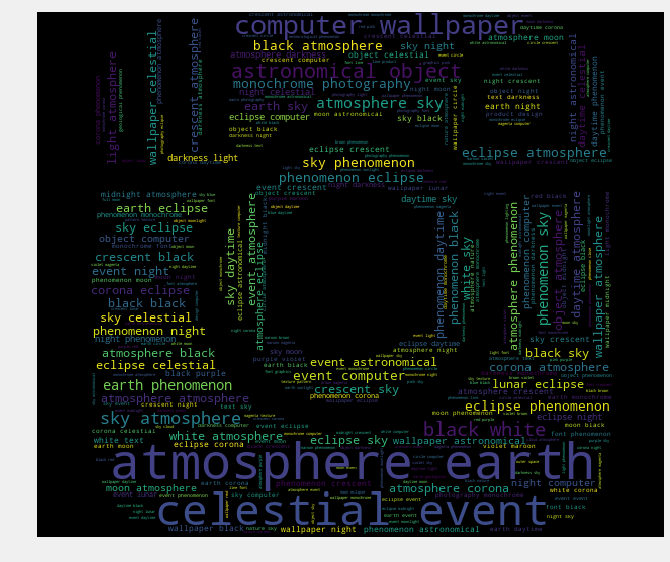

In [17]:
f1=open("insta.png", "wb")
f1.write(codecs.decode(insta,'base64'))
f1.close()
img1 = imread("insta.png")
hcmask1 = img1
wc = WordCloud(background_color="black", max_words=1000, mask=hcmask1, 
               stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(labels))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

As expected, the algorithm generated keywords related to celestial bodies,eclipse, colur of the sky, etc.

## User with Highest Clicks

In [18]:
Query1="""
Select lon,lat,user,model,storage_uri,state,is_mobile,height,width
From (
      Select lon,lat,user,model,storage_uri,state,is_mobile,height,width
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      UNION ALL
      Select lon,lat,user,model,storage_uri,state,is_mobile,height,width
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      UNION ALL
      Select lon,lat,user,model,storage_uri,state,is_mobile,height,width
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      )
"""
user_loc=bq_assistant.query_to_pandas_safe(Query1)
user_loc.dropna(inplace=True)

In [19]:
Query="""
SELECT user, COUNT(user) 
FROM (
Select user
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      UNION ALL
      Select user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      UNION ALL
      Select user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
) 
GROUP BY user 
HAVING COUNT (user)=( 
SELECT MAX(mycount) 
FROM ( 
SELECT user, COUNT(user) mycount 
FROM (
Select user
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      UNION ALL
      Select user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      UNION ALL
      Select user
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
)
GROUP BY user))
"""
max_user=bq_assistant.query_to_pandas_safe(Query)

In [20]:
max_user=user_loc[user_loc['user'].isin(max_user['user'])]
print('Maximum Photos was taken by user',max_user['user'].unique()[0],'with',max_user.shape[0],'photos')

Maximum Photos was taken by user 0bbc1d2d9453456898c02b77f2bc33f3 with 3082 photos


### Camera's used By the Top Photographer

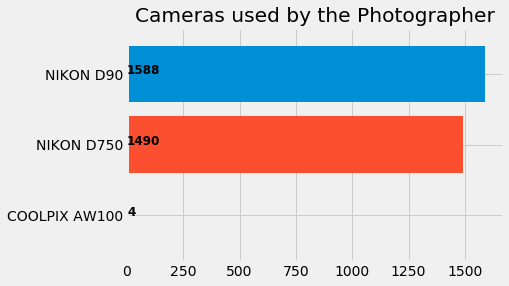

In [21]:
ax=max_user['model'].value_counts().plot.barh(width=0.8)
for i, v in enumerate(max_user['model'].value_counts().values): 
    ax.text(.8, i, v,fontsize=12,color='black',weight='bold')
plt.title('Cameras used by the Photographer')
plt.gca().invert_yaxis()

## Mapping All The Users (Dataset Inspiration)

As stated in the dataset, the inspiration of the dataset is to map the locations of the project contributors i.e the photographers. We will using a Folium Map for doing so. We will locate each photographer on the map and check how many were in and out of the **Path of Totality**.

### Path Of Totality

The path of totality in layman terms is the line along which the solar eclipse motion is followed. It is mostly a straight line, but it looks curved due to the earth's curved surface.

In [22]:
user_loc=user_loc.drop_duplicates(subset=['user'])
locate=user_loc[['lat','lon']]
model=user_loc['model']
state=user_loc['state']
height=user_loc['height']
width=user_loc['width']
img=user_loc['storage_uri']
mob_cam=user_loc['is_mobile']
def color(value):
    if value==True:
        return 'green'
    else:
        return 'red'

In [23]:
map1 = folium.Map(location=[39.50, -98.35],tiles='CartoDB dark_matter',zoom_start=3.5)
for point in user_loc.index:
    info='<b>Model:</b>'+str(model[point])+'<br><b>State</b>: '+str(state[point])+'<br><b>Img Height</b>: '+str(height[point])+'px'+'<br><b>Img Width</b>: '+str(width[point])+'px'+'<br><b>Img Src</b>: '+str(img[point])
    iframe = folium.IFrame(html=info, width=250, height=250)
    folium.CircleMarker(list(locate.loc[point].values),popup=folium.Popup(iframe),radius=1,color=color(mob_cam[point])).add_to(map1)
map1

The above map plots the users by their location of photographers. The green points are for users who clicked photos using their cellphones, whereas the red points are those who clicked photos using professional camera's.

We can clearly see the **Path of Totality**, from the north-west part of USA to south-eastern part. As far as I know the USA map, the states of Wyoming, Oregon, Georgia, South Carolina, Illinois, and many more fall under the path of totality. 

Almost all photgraphers were in the path os totality, sparring a few who were at the south-western and north-eastern parts of USA. And also a single user from UK maybe....lol!!

So we have located all the contributors of the project, and can see how many of them were in and away from the path of totallity
Click on the points to get additional informtion. Copy the link in another tab from the popup to see the image.

## Mapping Photos Taken By Hours

In [24]:
Query="""
Select lat,lon,EXTRACT(HOUR from image_datetime) as hour
FROM (
Select lat,lon,image_datetime
      From `bigquery-public-data.eclipse_megamovie.photos_v_0_1`
      where image_datetime Is Not Null and lat is not Null and lon is not Null
      UNION ALL
      Select lat,lon,image_datetime
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_2`
      where image_datetime Is Not Null and lat is not Null and lon is not Null
      UNION ALL
      Select lat,lon,image_datetime
      From`bigquery-public-data.eclipse_megamovie.photos_v_0_3`
      where image_datetime Is Not Null and lat is not Null and lon is not Null
) """
rel=bq_assistant.query_to_pandas_safe(Query)

In [ ]:
fig=plt.figure(figsize=(10,8))
from mpl_toolkits.basemap import Basemap
from matplotlib import animation,rc
fig.text(.3, .1, '21 August 2017', ha='right')
def animate(Hour):
    ax = plt.axes()
    ax.clear()
    ax.set_title('Photos Clicked '+'\n'+'Hour:' +str(Hour))
    m6 = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    lat_gif1=list(rel[rel['hour']==Hour].lat)
    long_gif1=list(rel[rel['hour']==Hour].lon)
    x_gif1,y_gif1=m6(long_gif1,lat_gif1)
    m6.scatter(x_gif1, y_gif1,color ='r') 
    m6.drawcoastlines()
    m6.drawcountries()
    m6.fillcontinents(color='coral',lake_color='aqua', zorder = 1,alpha=0.4)
    m6.drawmapboundary(fill_color='aqua')
ani = animation.FuncAnimation(fig,animate,list(rel.hour.unique()), interval = 1500)    
ani.save('animation.gif', writer='imagemagick', fps=1)
plt.close(1)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

The above animation shows the loactions of photos taken by hours. It is evident that the maximum number of photos were taken in the hours -17 and 18.

I hope this notebook proved to be a good source for getting started with BigQuery. If u liked the notebook **Do Upvote**.

## Thank You